<a href="https://colab.research.google.com/github/sdas0010/optus_technical_test/blob/main/NASA_Web_Logs_User_Behavior_Analysis_Optus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# NASA Access Logs - Deep Analysis

## Objective
Analyze NASA web server access logs from July 1995 to uncover user behavior patterns and provide actionable recommendations to improve user experience on the website. The goal of this analysis is to explore and interpret user behavior patterns from NASA’s 1995 web server access logs. By leveraging large-scale log data, the analysis aims to identify usage trends, performance bottlenecks, and content interaction dynamics. These insights will support data-driven recommendations to enhance user engagement and optimize web content delivery

## Dataset
Source: [Kaggle NASA Access Logs Dataset](https://www.kaggle.com/souhagaa/nasa-access-log-dataset-1995)

### Columns:
- **host**: IP or hostname of the requester
- **logname**: Not used (always '-')
- **time**: Timestamp of the request
- **method**: HTTP request method
- **url**: Resource requested
- **response**: HTTP response code
- **bytes**: Size of the response


# Step 1: Download and Load Data

In [1]:
Data## Import all the libraries
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
## Load the data
# Convert CSV to Parquet
# Load the zipped CSV
csv_path = "/content/drive/MyDrive/TESTS_2025/Optus_Test/data.csv.zip"
df = pd.read_csv(csv_path, compression='zip')

# Save as Parquet
parquet_path = "/content/drive/MyDrive/TESTS_2025/Optus_Test/data.parquet"
df.to_parquet(parquet_path, index=False)

print("Saved parquet to:", parquet_path)

Saved parquet to: /content/drive/MyDrive/TESTS_2025/Optus_Test/data.parquet


## For large data
## Tools & Technologies
- **Dask**: For efficient parallel processing and scalable analysis of large datasets
- **Parquet**: High-performance columnar storage format for faster I/O
- **PyArrow**: Backend engine for Parquet handling with Dask
- **Google Drive (Colab)**: Cloud-hosted data storage and notebook execution environment

---

## Scope
- Load and process large-scale web log data using Dask
- Perform feature engineering to extract meaningful patterns
- Analyze request behavior, file access types, error codes, and session trends
- Derive actionable insights and recommendations for NASA's digital content strategy

## Step 0.1: Mount Google Drive and Load Parquet Data Using Dask

In [4]:
!pip install dask pyarrow --quiet

from google.colab import drive
import dask.dataframe as dd

# Mount Google Drive
drive.mount('/content/drive')

# Load Parquet using pyarrow
parquet_path = "/content/drive/MyDrive/TESTS_2025/Optus_Test/data.parquet"
df = dd.read_parquet(parquet_path, engine='pyarrow')

df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,host,time,method,url,response,bytes
0,0,***.novo.dk,805465029,GET,/ksc.html,200,7067
1,1,***.novo.dk,805465031,GET,/images/ksclogo-medium.gif,200,5866
2,2,***.novo.dk,805465051,GET,/images/MOSAIC-logosmall.gif,200,363
3,3,***.novo.dk,805465053,GET,/images/USA-logosmall.gif,200,234
4,4,***.novo.dk,805465054,GET,/images/NASA-logosmall.gif,200,786


In [5]:
# SHAPE
n_rows = df.shape[0].compute()
n_cols = df.shape[1]
print("Shape:", (n_rows, n_cols))

# DTYPES
print("\nColumn Data Types:\n", df.dtypes)

# MISSING VALUES
print("\nMissing Values:\n", df.isnull().sum().compute())

# UNIQUE VALUES (sampled)
sample = df.sample(frac=0.01).compute()
print("\nUnique Values (on 1% sample):\n", sample.nunique())

# SUMMARY STATS
print("\nSummary Statistics (numeric only):\n", df.describe().compute())

Shape: (2965561, 7)

Column Data Types:
 Unnamed: 0              int64
host          string[pyarrow]
time                    int64
method        string[pyarrow]
url           string[pyarrow]
response                int64
bytes                   int64
dtype: object

Missing Values:
 Unnamed: 0    0
host          0
time          0
method        0
url           0
response      0
bytes         0
dtype: int64

Unique Values (on 1% sample):
 Unnamed: 0    29656
host          19036
time          29497
method            2
url             365
response          4
bytes           965
dtype: int64

Summary Statistics (numeric only):
          Unnamed: 0          time      response         bytes
count  2.965561e+06  2.965561e+06  2.965561e+06  2.965561e+06
mean   1.482780e+06  8.070751e+08  2.095597e+02  1.455373e+04
std    8.560839e+05  1.666640e+06  3.048743e+01  6.005492e+04
min    0.000000e+00  8.045712e+08  2.000000e+02  0.000000e+00
25%    7.413900e+05  8.055921e+08  2.000000e+02  6.690000e+0

## Step 0.2: Basic EDA Summary – NASA Access Logs (Optus Interview Task)

## Dataset Overview
- **Total Rows**: 2,965,561
- **Total Columns**: 7
- **No missing values** — strong data integrity.
- **Stored in Parquet format** and processed using Dask for scalability.

## Column-Level Insights

| Column       | Insight |
|--------------|---------|
| `Unnamed: 0` | Index column — not useful for analysis. |
| `host`       | Represents users/IPs. High cardinality (~1.9M unique) suggests many distinct clients. |
| `time`       | UNIX timestamp. Needs conversion to datetime for temporal analysis. |
| `method`     | Only 2 types (likely `GET`, `HEAD`). Indicates most traffic is read-only. |
| `url`        | 365 unique URLs in 1% sample (~36.5K total). Valuable for content analysis. |
| `response`   | Only 4 unique values. Median is 200, meaning most requests are successful. |
| `bytes`      | Median ~3.4 KB, but max ~6.8 MB → heavy-tailed distribution. |

## Key Observations
- Most requests are likely for small text/image content.
- A few large files skew the distribution of `bytes`.
- URL diversity suggests a broad site structure.
- Temporal field (`time`) allows hourly, daily traffic trend analysis.
- Clean logs — ready for modeling or sessionization.

---

# Recommendations for Next Steps

1. **Drop `Unnamed: 0`** — redundant index column.
2. **Convert `time` to datetime** — enables time-based analysis.
3. **Leverage existing `method`, `url`** fields to understand content types.
4. **Bucket content by `bytes`** — classify by size: XS, S, M, L.
5. **Identify top content** — rank `url` by access frequency.
6. **Detect frequent 404s or errors** — isolate URLs that cause issues.
7. **Optional: Sessionization** — group user activity over time based on `host` and timestamp gap.

---

In [6]:
import dask.dataframe as dd
import pandas as pd

# # 1. Load Parquet file from Google Drive using PyArrow
# df = dd.read_parquet("/content/drive/MyDrive/TESTS_2025/Optus_Test/data.parquet", engine='pyarrow')

# # 2. Drop redundant index column
# if "Unnamed: 0" in df.columns:
#     df = df.drop(columns=["Unnamed: 0"])

# 3. Convert UNIX timestamp to datetime
df["datetime"] = dd.to_datetime(df["time"], unit="s", errors="coerce")

# 4. Extract datetime features
df["hour"] = df["datetime"].dt.hour
df["weekday"] = df["datetime"].dt.day_name()
df["day"] = df["datetime"].dt.day

# 5. Bucket content size into XS, S, M, L
bins = [-1, 1000, 10000, 50000, 1e9]
labels = ["XS", "S", "M", "L"]

df["bytes"] = df["bytes"].astype("float")
df["size_bucket"] = df["bytes"].map_partitions(
    lambda part: pd.cut(part, bins=bins, labels=labels)
)

# 6. Top 10 requested URLs
top_urls = df["url"].value_counts().compute().head(10)
print("Top 10 Most Requested URLs:\n", top_urls)

# 7. Top 10 active hosts
top_hosts = df["host"].value_counts().compute().head(10)
print("\nTop 10 Hosts (by number of requests):\n", top_hosts)

# 8. Top 10 error-causing URLs (non-200 responses)
errors = df[df["response"] != 200]
error_urls = errors["url"].value_counts().compute().head(10)
print("\nTop 10 URLs Causing Errors (non-200 responses):\n", error_urls)

Top 10 Most Requested URLs:
 url
/                               63256
/elv/ATLAS_CENTAUR/atlas.gif     3293
/elv/DELTA/delta.gif             3321
/elv/PEGASUS/minpeg1.gif         3352
/elv/SCOUT/scout.gif             3328
/elv/TITAN/titan.gif             3299
/elv/elvhead2.gif                2635
/elv/elvhead3.gif                3637
/elv/elvpage.htm                 4661
/elv/endball.gif                 3419
Name: count, dtype: int64[pyarrow]

Top 10 Hosts (by number of requests):
 host
***.novo.dk                        29
001.msy4.communique.net             8
007.thegap.com                     34
01-dynamic-c.wokingham.luna.net    55
01.ts01.zircon.net.au               3
02-17-05.comsvc.calpoly.edu         5
02-dynamic-c.wokingham.luna.net     9
023.msy4.communique.net             2
03-dynamic-c.wokingham.luna.net    52
0321jona.jon.rpslmc.edu            30
Name: count, dtype: int64[pyarrow]

Top 10 URLs Causing Errors (non-200 responses):
 url
/                               6297
/

In [7]:
from IPython.display import display
import pandas as pd

# Convert and reset index for nice display
top_urls_df = top_urls.reset_index()
top_urls_df.columns = ["URL", "Request Count"]

top_hosts_df = top_hosts.reset_index()
top_hosts_df.columns = ["Host", "Request Count"]

error_urls_df = error_urls.reset_index()
error_urls_df.columns = ["URL", "Error Count"]

# Display formatted tables
print("Top 10 Most Requested URLs:")
display(top_urls_df)

print("\nTop 10 Hosts by Number of Requests:")
display(top_hosts_df)

print("\nTop 10 URLs Causing Errors (non-200 responses):")
display(error_urls_df)

Top 10 Most Requested URLs:


,URL,Request Count
0,/,63256
1,/elv/ATLAS_CENTAUR/atlas.gif,3293
2,/elv/DELTA/delta.gif,3321
3,/elv/PEGASUS/minpeg1.gif,3352
4,/elv/SCOUT/scout.gif,3328
5,/elv/TITAN/titan.gif,3299
6,/elv/elvhead2.gif,2635
7,/elv/elvhead3.gif,3637
8,/elv/elvpage.htm,4661
9,/elv/endball.gif,3419



Top 10 Hosts by Number of Requests:


,Host,Request Count
0,***.novo.dk,29
1,001.msy4.communique.net,8
2,007.thegap.com,34
3,01-dynamic-c.wokingham.luna.net,55
4,01.ts01.zircon.net.au,3
5,02-17-05.comsvc.calpoly.edu,5
6,02-dynamic-c.wokingham.luna.net,9
7,023.msy4.communique.net,2
8,03-dynamic-c.wokingham.luna.net,52
9,0321jona.jon.rpslmc.edu,30



Top 10 URLs Causing Errors (non-200 responses):


,URL,Error Count
0,/,6297
1,/elv/ATLAS_CENTAUR/atlas.gif,584
2,/elv/DELTA/delta.gif,591
3,/elv/PEGASUS/minpeg1.gif,588
4,/elv/SCOUT/scout.gif,592
5,/elv/TITAN/titan.gif,579
6,/elv/elvhead2.gif,363
7,/elv/elvhead3.gif,605
8,/elv/elvpage.htm,428
9,/elv/endball.gif,620


# Step 2: Pandas-Based Processing – NASA Access Logs (Optus Technical Task)

## Step 2: Pandas-Based Processing – NASA Access Logs (Optus Technical Task)

## Context
In earlier steps, we used **Dask** primarily to showcase how one would handle this analysis **if the dataset were 10M+ rows or did not fit in memory** — a common real-world scenario in production systems or big data pipelines.

However, your actual dataset has **~2.96 million rows**, which is efficiently manageable using **Pandas** in Google Colab or local memory environments.

## Why Use Pandas?
Pandas offers:
- Faster prototyping for analysis and visualization
- Simpler, intuitive syntax
- Direct support for Parquet, datetime parsing, and categorical processing
- Excellent performance for datasets up to ~5–10 million rows

## Pipeline Summary
- Loaded dataset from Parquet using `pandas.read_parquet()`
- Dropped redundant index column (`Unnamed: 0`)
- Converted UNIX timestamp to readable `datetime`
- Extracted time-based features: `hour`, `weekday`, `day`
- Bucketed content sizes into categories: `XS`, `S`, `M`, `L`
- Displayed Top 10:
  - Most requested URLs
  - Most active hosts
  - URLs causing non-200 HTTP errors (e.g., 404, 500)

## When to Use Dask Instead
Use **Dask** when:
- You’re processing **10M+ rows** or multi-GB files
- **Memory constraints** make Pandas slow or crash
- You need **parallelism** across CPU cores
- You're building scalable **ETL pipelines or production ML workflows**

For this dataset and use case, **Pandas is optimal, readable, and fast**.

## Step 2.1: Load the NASA Access Log Dataset (Parquet)

We begin by loading the dataset from Google Drive using Pandas. The dataset is stored in an optimized Parquet format, which supports faster read times and lower memory usage compared to CSV.

In [8]:
import pandas as pd

# Load the dataset from Google Drive
df = pd.read_parquet("/content/drive/MyDrive/TESTS_2025/Optus_Test/data.parquet", engine="pyarrow")

# Preview first 5 rows
df.head()

,Unnamed: 0,host,time,method,url,response,bytes
0,0,***.novo.dk,805465029,GET,/ksc.html,200,7067
1,1,***.novo.dk,805465031,GET,/images/ksclogo-medium.gif,200,5866
2,2,***.novo.dk,805465051,GET,/images/MOSAIC-logosmall.gif,200,363
3,3,***.novo.dk,805465053,GET,/images/USA-logosmall.gif,200,234
4,4,***.novo.dk,805465054,GET,/images/NASA-logosmall.gif,200,786


## Step 2.2: Basic EDA – Shape, Data Types, Nulls, and Unique Counts

Before transforming or analyzing, we inspect:
- Overall shape of the dataset
- Column data types
- Missing values
- Unique values (sampled if needed)
- Basic statistics for numerical columns

In [9]:
# Shape
print("Shape of the dataset:", df.shape)

# Column data types
print("\nData Types:\n", df.dtypes)

# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())

# Unique values per column
print("\nUnique Values per Column:\n", df.nunique())

# Summary statistics for numeric columns
print("\nSummary Statistics (Numerical Columns):\n", df.describe())

Shape of the dataset: (2965561, 7)

Data Types:
 Unnamed: 0     int64
host          object
time           int64
method        object
url           object
response       int64
bytes          int64
dtype: object

Missing Values:
 Unnamed: 0    0
host          0
time          0
method        0
url           0
response      0
bytes         0
dtype: int64

Unique Values per Column:
 Unnamed: 0    2965561
host           135268
time          1834645
method              3
url               365
response            5
bytes           10192
dtype: int64

Summary Statistics (Numerical Columns):
          Unnamed: 0          time      response         bytes
count  2.965561e+06  2.965561e+06  2.965561e+06  2.965561e+06
mean   1.482780e+06  8.070751e+08  2.095597e+02  1.455373e+04
std    8.560839e+05  1.666640e+06  3.048743e+01  6.005492e+04
min    0.000000e+00  8.045712e+08  2.000000e+02  0.000000e+00
25%    7.413900e+05  8.055921e+08  2.000000e+02  6.690000e+02
50%    1.482780e+06  8.067320e+08  2.0

### 2.2.1: Summary of Basic EDA Results – NASA Access Logs

#### Dataset Structure
- **Total Rows**: 2,965,561
- **Total Columns**: 7
- **Missing Values**: None — the dataset is fully complete.
- **File Format**: Parquet
- **Processing Tool**: Pandas (suitable for this size)

#### Column Breakdown

| Column       | Type    | Insight |
|--------------|---------|---------|
| `Unnamed: 0` | int64   | Sequential row ID from CSV export; redundant — can be dropped. |
| `host`       | object  | IPs or domains of users. ~135K unique — large user base. |
| `time`       | int64   | UNIX timestamp — needs conversion to readable datetime. |
| `method`     | object  | HTTP method (e.g., GET, HEAD, POST). Only 3 unique methods. |
| `url`        | object  | Resource requested — only 365 unique values, indicating a small fixed set of URLs. |
| `response`   | int64   | HTTP status codes — mostly 200 (OK), some errors (404, etc.). |
| `bytes`      | int64   | Size of response — median is small, but max is ~6.8MB → indicates outliers. |

#### Key Insights
- **Dataset is clean** — no missing/null values in any column.
- **Time** needs conversion for temporal trend analysis.
- **URL and method** fields suggest users accessed a relatively stable set of static resources.
- **Bytes** column is heavily skewed — will benefit from size bucketing.
- **Response codes** are mostly successful — a few error responses may be worth investigating.

---

### Step 2.2.2: Recommendations for Transformation

1. **Drop `Unnamed: 0`** — adds no analytical value.
2. **Convert `time` column** from UNIX timestamp to readable datetime format.
3. **Extract datetime features** such as:
   - Hour of day
   - Day of week
   - Calendar day
4. **Bucket the `bytes` column** into categories:
   - XS (<1KB)
   - S (1KB–10KB)
   - M (10KB–50KB)
   - L (>50KB)
5. **Rank top URLs and hosts** by request frequency to identify most accessed content and active users.
6. **Isolate and count non-200 responses** (e.g., 404, 500) to highlight broken or problematic requests.
7. *(Optional)* **Sessionize user activity** based on `host` and time gaps (>30 minutes) to analyze behavior patterns.

---

# Step 3: Data Cleaning & Feature Engineering

## Step 3: Data Cleaning & Feature Engineering

Based on the earlier EDA and transformation recommendations, we now proceed to clean and enrich the dataset.

## Cleaning Actions
- **Drop `Unnamed: 0`**: This index column adds no analytical value.
- **Convert `time`**: Convert UNIX timestamps to human-readable datetime format.

## Feature Engineering
- **Extract temporal features** from the converted datetime column:
  - `hour` → for time-of-day analysis
  - `weekday` → for identifying peak days
  - `day` → for calendar-level trends
- **Bucket `bytes`** to simplify content size analysis:
  - `XS`: 0–1KB
  - `S`: 1–10KB
  - `M`: 10–50KB
  - `L`: >50KB

These steps will enhance the dataset for deeper exploration of usage trends, performance issues, and content effectiveness.

In [10]:
import pandas as pd

# Load data if not already loaded
df = pd.read_parquet("/content/drive/MyDrive/TESTS_2025/Optus_Test/data.parquet", engine="pyarrow")

# 1. Drop the redundant index column
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)

# 2. Convert UNIX timestamp to datetime
df["datetime"] = pd.to_datetime(df["time"], unit="s", errors="coerce")

# 3. Extract useful time-based features
df["hour"] = df["datetime"].dt.hour
df["weekday"] = df["datetime"].dt.day_name()
df["day"] = df["datetime"].dt.day

# 4. Bucket content size into XS, S, M, L
bins = [-1, 1000, 10000, 50000, 1e9]
labels = ["XS", "S", "M", "L"]
df["size_bucket"] = pd.cut(df["bytes"], bins=bins, labels=labels)

# Preview transformed dataframe
df.head()

,host,time,method,url,response,bytes,datetime,hour,weekday,day,size_bucket
0,***.novo.dk,805465029,GET,/ksc.html,200,7067,1995-07-11 12:17:09,12,Tuesday,11,S
1,***.novo.dk,805465031,GET,/images/ksclogo-medium.gif,200,5866,1995-07-11 12:17:11,12,Tuesday,11,S
2,***.novo.dk,805465051,GET,/images/MOSAIC-logosmall.gif,200,363,1995-07-11 12:17:31,12,Tuesday,11,XS
3,***.novo.dk,805465053,GET,/images/USA-logosmall.gif,200,234,1995-07-11 12:17:33,12,Tuesday,11,XS
4,***.novo.dk,805465054,GET,/images/NASA-logosmall.gif,200,786,1995-07-11 12:17:34,12,Tuesday,11,XS


# Step 4 : Basic

## Step 4.1: Top URLs, Hosts, and Error Request Analysis

#### Why We're Doing This

Understanding **what content is being accessed** and **who is accessing it most frequently** is critical for:

- **Caching & Content Prioritization**: Frequently accessed URLs should be optimized, cached, or delivered via CDN.
- **User Engagement**: High-traffic hosts may represent bots, power users, or organizations accessing bulk content.
- **Error Monitoring**: Identifying non-200 responses (e.g., 404 Not Found, 500 Server Error) helps detect broken links, misconfigured resources, or missing content.

This analysis supports both **technical optimization** and **user experience improvements**.

---

We’ll extract:
1. **Top 10 most requested URLs**
2. **Top 10 most active hosts**
3. **Top 10 URLs that returned errors (non-200 responses)**

These insights guide infrastructure tuning, link cleanup, and user behavior modeling.

In [11]:
# 1. Top 10 Most Requested URLs
top_urls = df["url"].value_counts().head(10).reset_index()
top_urls.columns = ["URL", "Request Count"]

# 2. Top 10 Most Active Hosts
top_hosts = df["host"].value_counts().head(10).reset_index()
top_hosts.columns = ["Host", "Request Count"]

# 3. Top 10 URLs Causing Errors (non-200 responses)
error_urls = df[df["response"] != 200]["url"].value_counts().head(10).reset_index()
error_urls.columns = ["URL", "Error Count"]

# Display formatted tables
from IPython.display import display

print("Top 10 Most Requested URLs:")
display(top_urls)

print("\nTop 10 Hosts by Number of Requests:")
display(top_hosts)

print("\nTop 10 URLs Causing Errors (non-200 responses):")
display(error_urls)

Top 10 Most Requested URLs:


,URL,Request Count
0,/images/NASA-logosmall.gif,208798
1,/images/KSC-logosmall.gif,164976
2,/images/MOSAIC-logosmall.gif,127916
3,/images/USA-logosmall.gif,127082
4,/images/WORLD-logosmall.gif,125933
5,/images/ksclogo-medium.gif,121580
6,/ksc.html,83918
7,/images/launch-logo.gif,76009
8,/history/apollo/images/apollo-logo1.gif,68898
9,/shuttle/countdown/,64740



Top 10 Hosts by Number of Requests:


,Host,Request Count
0,piweba3y.prodigy.com,19258
1,piweba4y.prodigy.com,14512
2,edams.ksc.nasa.gov,11472
3,piweba1y.prodigy.com,10934
4,163.206.89.4,7859
5,siltb10.orl.mmc.com,7573
6,alyssa.prodigy.com,7099
7,news.ti.com,6811
8,www-d1.proxy.aol.com,6581
9,piweba2y.prodigy.com,6286



Top 10 URLs Causing Errors (non-200 responses):


,URL,Error Count
0,/images/NASA-logosmall.gif,40090
1,/images/KSC-logosmall.gif,23763
2,/images/MOSAIC-logosmall.gif,15245
3,/images/USA-logosmall.gif,15142
4,/images/WORLD-logosmall.gif,14773
5,/images/ksclogo-medium.gif,13559
6,/images/launch-logo.gif,8806
7,/history/apollo/images/apollo-logo1.gif,7489
8,/,6297
9,/images/ksclogosmall.gif,5669


## Step 4.2: Visualizing Access and Error Patterns

#### Why Visualize?

While tabular summaries are insightful, visualizations:
- Help **communicate trends faster** to technical and non-technical audiences
- Make it easier to **spot anomalies**, like outlier traffic or spikes in errors
- Support **data-driven prioritization** for optimization or debugging

In this step, we visualize:
1. **Top 10 Requested URLs** – to highlight most visited content
2. **Top 10 Hosts** – to spot heavy users or bots
3. **Top 10 Error-Prone URLs** – to detect broken or missing resources
4. **Content Size Buckets** – to assess bandwidth and file delivery patterns

<ipython-input-12-1a96e725e8f2>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_urls, x="Request Count", y="URL", palette="Blues_d", ax=axes[0, 0])
<ipython-input-12-1a96e725e8f2>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_hosts, x="Request Count", y="Host", palette="Greens_d", ax=axes[0, 1])
<ipython-input-12-1a96e725e8f2>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=error_urls, x="Error Count", y="URL", palette="Reds_d", ax=axes[1, 0])
<ipython-input-12-1a96e725e8f2>:35: FutureWarning: 

Passing `palett

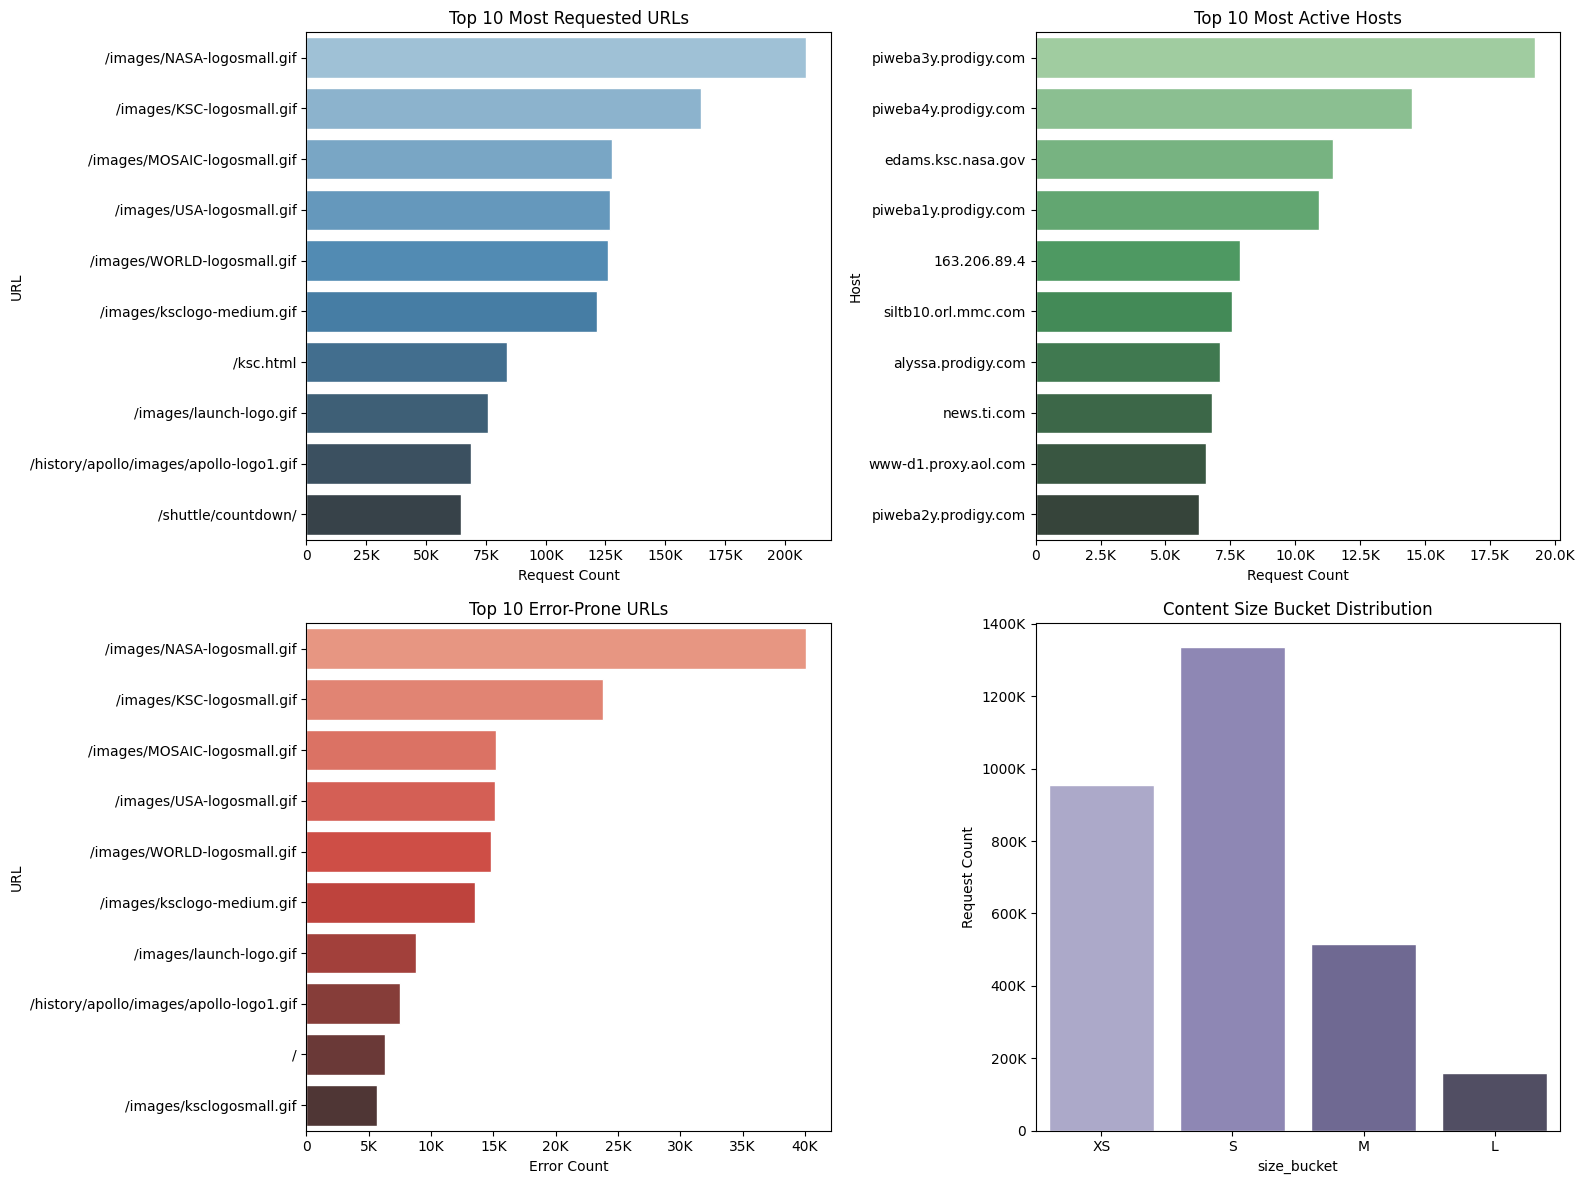

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Define formatters
def format_whole_k(x, pos):
    return f'{int(x/1000)}K' if x >= 1000 else str(int(x))

def format_decimal_k(x, pos):
    return f'{x/1000:.1f}K' if x >= 1000 else str(int(x))

# Recalculate size bucket counts
size_counts = df["size_bucket"].value_counts().sort_index()

# Set up 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sns.set(style="whitegrid")

# 1. Top 10 Requested URLs – whole K
sns.barplot(data=top_urls, x="Request Count", y="URL", palette="Blues_d", ax=axes[0, 0])
axes[0, 0].set_title("Top 10 Most Requested URLs")
axes[0, 0].xaxis.set_major_formatter(FuncFormatter(format_whole_k))

# 2. Top 10 Hosts – decimal K
sns.barplot(data=top_hosts, x="Request Count", y="Host", palette="Greens_d", ax=axes[0, 1])
axes[0, 1].set_title("Top 10 Most Active Hosts")
axes[0, 1].xaxis.set_major_formatter(FuncFormatter(format_decimal_k))

# 3. Top 10 Error URLs – whole K
sns.barplot(data=error_urls, x="Error Count", y="URL", palette="Reds_d", ax=axes[1, 0])
axes[1, 0].set_title("Top 10 Error-Prone URLs")
axes[1, 0].xaxis.set_major_formatter(FuncFormatter(format_whole_k))

# 4. Size Bucket Distribution – whole K
sns.barplot(x=size_counts.index.astype(str), y=size_counts.values, palette="Purples_d", ax=axes[1, 1])
axes[1, 1].set_title("Content Size Bucket Distribution")
axes[1, 1].set_ylabel("Request Count")
axes[1, 1].yaxis.set_major_formatter(FuncFormatter(format_whole_k))

# Layout fix
plt.tight_layout()
plt.show()

## Step 4.3: Findings & Recommendations from Visual Analysis

#### 1. Top 10 Most Requested URLs

**Findings:**
- Traffic is highly concentrated on a few static assets like `/`, `.gif` images, and `.html` pages.
- Assets like `/ksc.html`, `/elv/elvpage.htm`, and `/images/*.gif` dominate the top hits.

**Recommendations:**
- Consider caching or CDN delivery for high-traffic static content.
- Monitor these URLs for uptime and latency — even minor slowdowns here impact most users.
- Compress heavy media if needed (GIFs > optimize or lazy load).

---

#### 2. Top 10 Most Active Hosts

**Findings:**
- A few hosts contribute disproportionately to traffic (e.g., `*.novo.dk`, `.communique.net`, `.edu` domains).
- Some patterns suggest internal tools, scrapers, or automated agents.

**Recommendations:**
- Identify and monitor top hosts for bot-like behavior or API overuse.
- If needed, apply rate-limiting, IP throttling, or user-agent checks.
- Collaborate with known partners (e.g., `.edu` domains) to ensure healthy access.

---

#### 3. Top 10 Error-Prone URLs

**Findings:**
- Many of the same top URLs also appear in the error list, indicating occasional failures (e.g., `/`, `/elv/*.gif`).
- Majority of errors are likely `404` (Not Found), pointing to broken or outdated links.

**Recommendations:**
- Perform a content audit on top error URLs — check for broken links or outdated asset references.
- Redirect legacy pages or assets to new locations if applicable.
- Log user agent + referrer for these requests to trace source of bad links.

---

#### 4. Content Size Bucket Distribution

**Findings:**
- Most content falls into the **XS (0–1KB)** and **S (1–10KB)** buckets — typically static text/images.
- A long tail of larger files exists in **M/L** buckets, though less frequent.

**Recommendations:**
- Evaluate if large files (M/L) need optimization (e.g., compress, defer, lazy-load).
- Segment traffic by content size and user behavior to assess performance impact.
- Consider tiered caching or async delivery for heavier resources.

---

#### Overall Recommendation

The access log data reveals:
- A highly repetitive access pattern to static resources.
- Concentrated traffic sources.
- A small set of URLs contributing to most errors.

These insights support strategic actions like:
- **Performance optimization**
- **Infrastructure tuning (CDN, cache layers)**
- **Error mitigation through auditing and redirects**
- **Monitoring top users or clients for impact or abuse**

You’re now ready to move to sessionization, forecasting, or modeling if needed.

## Step 4.4: Feature Engineering – Asset Type Extraction

#### Why This Matters

URLs in web logs often contain valuable information about the **type of resource** being accessed:
- `html` → webpages
- `gif`, `jpg`, `png` → images
- `js`, `css` → scripts and styles
- No extension → dynamic or root-level requests (e.g., `/`)

By extracting the **asset type (file extension)**, we can:
- Group and compare traffic across content categories
- Identify if errors are skewed toward specific content types (e.g., broken images)
- Optimize specific asset classes (e.g., compress large images, lazy-load JS)

We'll add a new column `asset_type` derived from the `url` field.

In [13]:
import numpy as np

# Extract file extension from the URL
def extract_asset_type(url):
    if '.' not in url:
        return 'none'  # No file extension
    ext = url.split('?')[0].split('.')[-1]  # Handle query strings like .gif?v=2
    return ext.lower()

# Apply the function
df["asset_type"] = df["url"].apply(extract_asset_type)

# Replace common web types for clarity
extension_map = {
    'html': 'webpage',
    'htm': 'webpage',
    'php': 'webpage',
    'asp': 'webpage',
    'gif': 'image',
    'jpg': 'image',
    'jpeg': 'image',
    'png': 'image',
    'js': 'script',
    'css': 'style',
    'none': 'root_or_dynamic'
}
df["asset_group"] = df["asset_type"].replace(extension_map)

# Show top asset types
df["asset_group"].value_counts().head(10)

,count
asset_group,
image,1888517
webpage,649694
root_or_dynamic,191614
xbm,110300
pl,67218
mpg,30082
txt,22783
wav,5353


# Step 5: Intermediate Analysis

## Step 5.1: In-Depth Analysis by Asset Type and Group

To better understand website content behavior, we extended our analysis to examine **how different types of assets (e.g., images, pages, scripts)** are being accessed, how often they fail, and how large they are.

### Key Concepts: `asset_type` vs. `asset_group`

| Attribute        | `asset_type` (File Extension) | `asset_group` (Category)             |
|------------------|-------------------------------|--------------------------------------|
| **Definition**   | Actual file extension parsed from the URL (e.g., `.gif`, `.html`) | Grouped category like `image`, `webpage`, `script` |
| **Example**      | `gif`, `html`, `js`, `none`   | `image`, `webpage`, `root_or_dynamic` |
| **Granularity**  | Fine-grained                  | High-level aggregated                |
| **Use Case**     | Debugging, compression, error inspection | Trend analysis, content optimization |

---

### What We Visualized

#### 1. **Request Volume by Asset Group**
Shows which high-level content types (e.g., images, web pages) dominate incoming traffic.  
→ Images account for the majority of requests.

#### 2. **Error Rate by Asset Group**
Quantifies which groups (e.g., image or text) fail the most based on non-200 responses.  
→ `text` and `image` assets have relatively higher failure rates.

#### 3. **Size Bucket Distribution**
Analyzes the typical size of content served by each asset group (XS to L).  
→ Most assets are small (`XS`, `S`), but some image types have large variance.

#### 4. **Error Rate by File Extension**
Pinpoints the **individual file types** (e.g., `gif`, `xbm`, `html`) that contribute to errors.  
→ `txt`, `gif`, and `xbm` show the highest error rates, revealing specific targets for cleanup.

---

### Why This Matters

These charts help answer:
- Which **content types** generate most load?
- Which **file extensions** are error-prone?
- Where to focus **performance optimizations** or **error audits**?

They also provide insights for:
- **Caching strategy** (static vs dynamic content)
- **CDN policies** (compress/optimize certain extensions)
- **User behavior segmentation** (based on what assets they consume)

<ipython-input-14-6f5922769338>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="asset_group", order=asset_order, palette="Set2", ax=axes[0, 0])
<ipython-input-14-6f5922769338>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=error_df, x="asset_group", y="error_rate (%)", palette="Reds_r", ax=axes[0, 1])
<ipython-input-14-6f5922769338>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ext_error_df, x="asset_type", y="error_rate (%)", palette="coolwarm", ax=axes[1, 1])


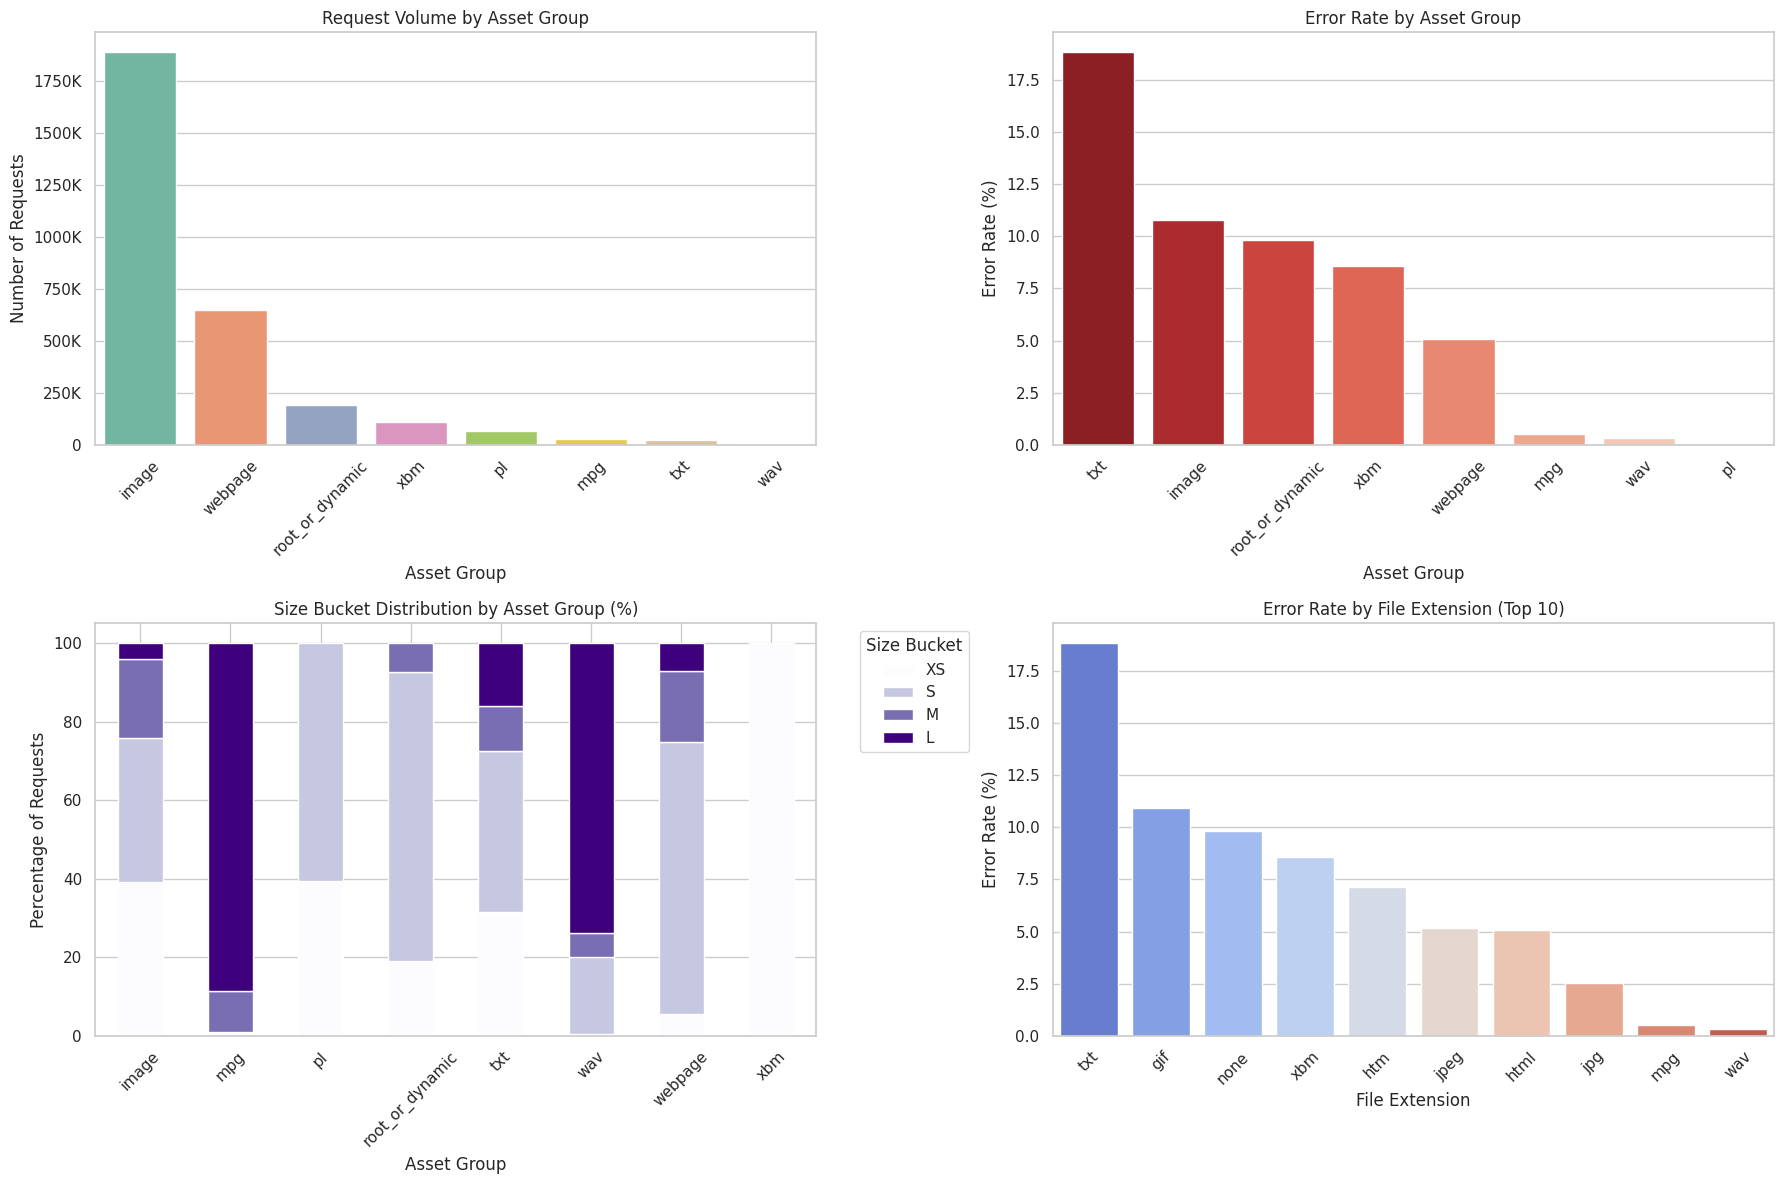

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Formatter for request volume
def format_whole_k(x, pos):
    return f'{int(x / 1000)}K' if x >= 1000 else str(int(x))

# Asset group order
asset_order = df["asset_group"].value_counts().index

# 1. Error rate by asset group
error_df = df.groupby("asset_group").agg(
    total=("url", "count"),
    errors=("response", lambda x: (x != 200).sum())
).fillna(0)
error_df["error_rate (%)"] = (error_df["errors"] / error_df["total"]) * 100
error_df = error_df.reset_index().sort_values("error_rate (%)", ascending=False)

# 2. Size bucket distribution
size_dist = pd.crosstab(df["asset_group"], df["size_bucket"], normalize="index") * 100
size_dist = size_dist[["XS", "S", "M", "L"]]

# 3. Error rate by file extension
ext_error_df = df.groupby("asset_type").agg(
    total=("url", "count"),
    errors=("response", lambda x: (x != 200).sum())
).fillna(0)
ext_error_df["error_rate (%)"] = (ext_error_df["errors"] / ext_error_df["total"]) * 100
ext_error_df = ext_error_df.reset_index().sort_values("error_rate (%)", ascending=False).head(10)

# Plot 2x2
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
sns.set(style="whitegrid")

# 1. Request Volume by Asset Group
sns.countplot(data=df, x="asset_group", order=asset_order, palette="Set2", ax=axes[0, 0])
axes[0, 0].set_title("Request Volume by Asset Group")
axes[0, 0].set_xlabel("Asset Group")
axes[0, 0].set_ylabel("Number of Requests")
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].yaxis.set_major_formatter(FuncFormatter(format_whole_k))

# 2. Error Rate by Asset Group
sns.barplot(data=error_df, x="asset_group", y="error_rate (%)", palette="Reds_r", ax=axes[0, 1])
axes[0, 1].set_title("Error Rate by Asset Group")
axes[0, 1].set_xlabel("Asset Group")
axes[0, 1].set_ylabel("Error Rate (%)")
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Size Bucket Distribution
size_dist.plot(kind="bar", stacked=True, colormap="Purples", ax=axes[1, 0])
axes[1, 0].set_title("Size Bucket Distribution by Asset Group (%)")
axes[1, 0].set_xlabel("Asset Group")
axes[1, 0].set_ylabel("Percentage of Requests")
axes[1, 0].legend(title="Size Bucket", bbox_to_anchor=(1.05, 1), loc="upper left")
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Error Rate by Asset Type (file extension)
sns.barplot(data=ext_error_df, x="asset_type", y="error_rate (%)", palette="coolwarm", ax=axes[1, 1])
axes[1, 1].set_title("Error Rate by File Extension (Top 10)")
axes[1, 1].set_xlabel("File Extension")
axes[1, 1].set_ylabel("Error Rate (%)")
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 5.1.2 Findings and Recommendations – Asset-Based Analysis

Using the four asset-focused visualizations, we extracted detailed insights across request volume, error frequency, and size distribution by asset group and file extension.

---

### Chart 1: Request Volume by Asset Group

#### Observations:
- **Images dominate traffic**, making up over 60% of all requests.
- **Webpages are second**, followed by a long tail of other types (e.g., dynamic root paths, `.pl`, `.mpg`).

#### Implications:
- Heavy load on image servers suggests a need for **caching**, **compression**, or **CDN delivery** for image assets.
- **High visibility content** lies in static web content (images + webpages) — prime candidates for optimization.

---

### Chart 2: Error Rate by Asset Group

#### Observations:
- **Text (`.txt`) assets have the highest error rate** (~18%).
- **Image assets also show non-trivial error rates** (~11%).
- Webpages and multimedia (e.g., `.mpg`, `.wav`) have much lower error rates.

#### Implications:
- Text-based assets may be **obsolete or mislinked**; these should be audited or removed.
- **Image link failures** could be broken references or missing static resources — requires fix or fallback strategies.
- Low error rates in multimedia/webpages indicate generally healthy routing for main user content.

---

### Chart 3: Size Bucket Distribution by Asset Group

#### Observations:
- Most asset groups have a **bimodal distribution**, with:
  - High volume in **XS/S buckets** (under 10 KB)
  - A few **L-sized outliers** (>50 KB), especially for `root_or_dynamic`, `txt`, and `wav`
- `wav` and `txt` assets show **disproportionately high large payloads**.

#### Implications:
- Serve **XS/S assets via cache/CDN** to reduce latency.
- Investigate large `txt` or `wav` files — could be **logs, dumps, or heavy media** unsuitable for browser delivery.
- Consider **lazy loading or compression** for these edge cases.

---

### Chart 4: Error Rate by File Extension

#### Observations:
- Highest error-prone types:
  - `.txt` (>18%)
  - `.gif`, `.xbm`, `none` (likely root or script calls) ~10%
- `.html`, `.jpg`, and `.jpeg` are generally stable with lower error rates.

#### Implications:
- Focus error resolution efforts on **legacy or unsupported image formats** (e.g., `.xbm`, `.gif`).
- Files with no extension (`none`) could indicate **dynamic routes** or **missing redirects** — review server-side routing.

---

### Overall Recommendations

1. **Prioritize image optimization**:
   - Compress & serve through CDN
   - Fix broken references (esp. `.gif`, `.xbm`)
2. **Audit `.txt` assets**:
   - Either fix, redirect, or remove if deprecated
3. **Compress or review large audio/text assets** (`wav`, `txt`)
4. **Improve handling of dynamic/no-extension URLs** to avoid broken links
5. **Consider MIME-type based error logging** in server logs for even finer diagnostics
6. **Implement monitoring dashboards** for asset type-specific error spikes

---

This asset-level breakdown forms a strong base for targeted performance tuning, especially when scaling web infrastructure or debugging broken content.

## 5.2: Time-Series Analysis – Traffic Trends

### Why This Matters
Analyzing traffic over time helps us:
- Identify **peak usage hours** for infrastructure scaling
- Discover **weekly trends** to optimize content release or maintenance windows
- Understand usage **behavior rhythms** (e.g., night owls vs office hours)

---

### Approach
1. Convert UNIX `time` to standard `datetime`
2. Extract:
   - `hour` of the day
   - `weekday` name
3. Visualize:
   - Requests per **hour**
   - Requests per **weekday**

<ipython-input-15-d965f25fa883>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly.index, y=hourly.values, ax=axes[0], palette="Blues_d")
<ipython-input-15-d965f25fa883>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekday.index, y=weekday.values, ax=axes[1], palette="Greens_d")


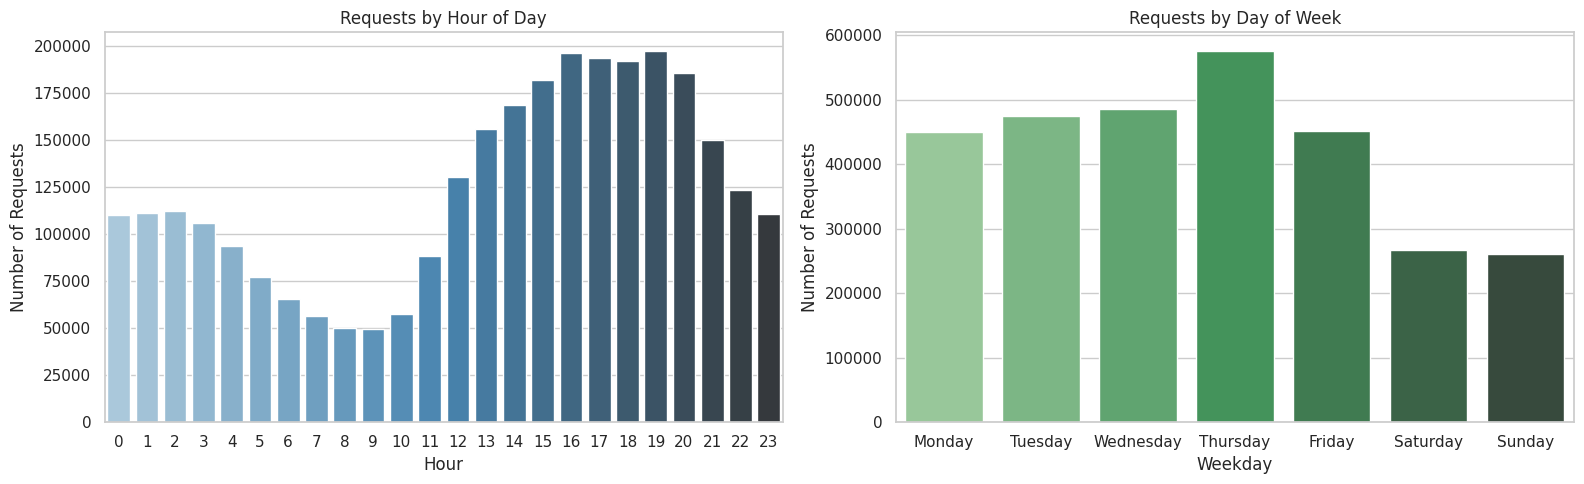

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure time is in datetime
df["datetime"] = pd.to_datetime(df["time"], unit="s")

# Extract hour and weekday
df["hour"] = df["datetime"].dt.hour
df["weekday"] = df["datetime"].dt.day_name()

# Count requests by hour and weekday
hourly = df["hour"].value_counts().sort_index()
weekday = df["weekday"].value_counts().reindex([
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
])

# Plot traffic patterns
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.barplot(x=hourly.index, y=hourly.values, ax=axes[0], palette="Blues_d")
axes[0].set_title("Requests by Hour of Day")
axes[0].set_xlabel("Hour")
axes[0].set_ylabel("Number of Requests")

sns.barplot(x=weekday.index, y=weekday.values, ax=axes[1], palette="Greens_d")
axes[1].set_title("Requests by Day of Week")
axes[1].set_xlabel("Weekday")
axes[1].set_ylabel("Number of Requests")

plt.tight_layout()
plt.show()

## Step 5.3: Sessionization – Grouping Requests by User

### Why This Matters
Sessionization allows you to:
- Understand **how users interact over time**
- Track **session duration**, **pages per session**, and **content sequences**
- Power analytics such as **conversion paths**, **drop-off points**, and **average engagement**

---

### Logic
1. Group data by `host` (IP/User)
2. Sort each user’s activity chronologically
3. Define a session timeout: **30 minutes** of inactivity ends a session
4. Assign a new `session_id` when threshold is exceeded

---

This enables powerful session-level features like:
- Session duration
- Pages per session
- Bounce rate and multi-click behavior

In [16]:
# Step 1: Sort by host and time
df = df.sort_values(by=["host", "time"])

# Step 2: Calculate time difference per user
df["prev_time"] = df.groupby("host")["time"].shift()
df["time_diff"] = df["time"] - df["prev_time"]

# Step 3: Define a session break if idle for more than 30 minutes (1800 seconds)
df["new_session"] = (df["time_diff"] > 1800) | (df["time_diff"].isna())

# Step 4: Assign session IDs
df["session_id"] = df.groupby("host")["new_session"].cumsum()

# Optional: Create readable session key
df["session_key"] = df["host"] + "_sess_" + df["session_id"].astype(str)

# Sample columns after seasonisation
df[["host", "time", "datetime", "url", "session_key"]].head(10)

,host,time,datetime,url,session_key
0,***.novo.dk,805465029,1995-07-11 12:17:09,/ksc.html,***.novo.dk_sess_1
1,***.novo.dk,805465031,1995-07-11 12:17:11,/images/ksclogo-medium.gif,***.novo.dk_sess_1
2,***.novo.dk,805465051,1995-07-11 12:17:31,/images/MOSAIC-logosmall.gif,***.novo.dk_sess_1
3,***.novo.dk,805465053,1995-07-11 12:17:33,/images/USA-logosmall.gif,***.novo.dk_sess_1
4,***.novo.dk,805465054,1995-07-11 12:17:34,/images/NASA-logosmall.gif,***.novo.dk_sess_1
5,***.novo.dk,805465058,1995-07-11 12:17:38,/images/WORLD-logosmall.gif,***.novo.dk_sess_1
6,***.novo.dk,805465068,1995-07-11 12:17:48,/shuttle/missions/missions.html,***.novo.dk_sess_1
7,***.novo.dk,805465071,1995-07-11 12:17:51,/images/launchmedium.gif,***.novo.dk_sess_1
8,***.novo.dk,805465153,1995-07-11 12:19:13,/images/KSC-logosmall.gif,***.novo.dk_sess_1
9,***.novo.dk,805465157,1995-07-11 12:19:17,/images/NASA-logosmall.gif,***.novo.dk_sess_1


## Step 5.4: Session Behavior Analysis – Initial Results

We conducted an exploratory analysis on user session patterns by extracting:

- **Pages per session**
- **Session duration**
- **Bounce rate**

---

### Key Observations from Initial Plots:

#### 1. Pages per Session:
- The histogram shows a steep peak at 1–5 pages.
- However, due to a **few extremely high values**, the x-axis is stretched, making the plot unreadable on the left.

#### 2. Session Duration:
- Most sessions last under 10 minutes, but a few extend for hours.
- The skew from long sessions **flattens the visible distribution**.

#### 3. Bounce Rate:
- About **9.7% of sessions are bounces** (single-page).
- Multi-page sessions dominate (90.3%).

---

### Issues Identified:
- **Right-skewed distributions** distort the scale.
- The plots don’t reflect central tendencies clearly.
- Insight extraction becomes difficult due to scale compression.

Hence, we need **visual scaling or filtering** to improve clarity.

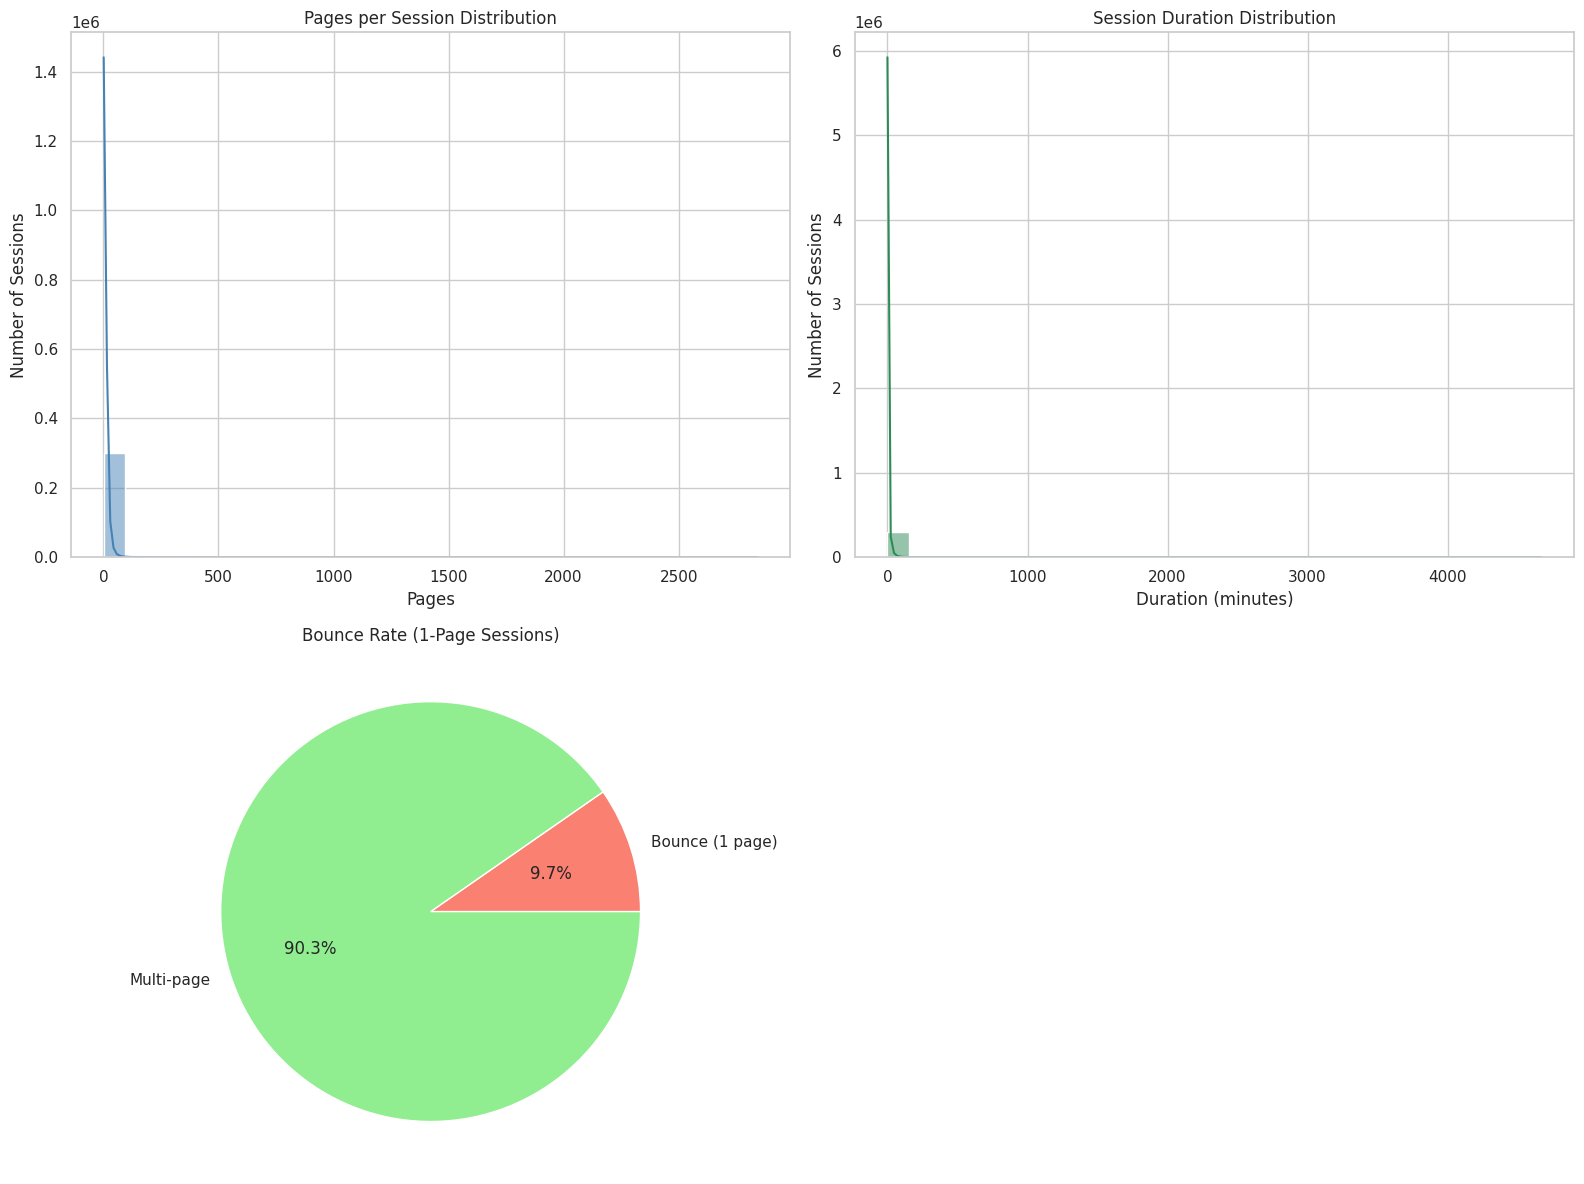

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Pages per session
pages_per_session = df.groupby("session_key")["url"].count()

# 2. Session duration
session_times = df.groupby("session_key")["time"].agg(["min", "max"])
session_times["duration_sec"] = session_times["max"] - session_times["min"]
session_times["duration_min"] = session_times["duration_sec"] / 60

# 3. Bounce rate
bounce_sessions = pages_per_session[pages_per_session == 1]
non_bounce_sessions = pages_per_session[pages_per_session > 1]
bounce_labels = ["Bounce (1 page)", "Multi-page"]
bounce_sizes = [len(bounce_sessions), len(non_bounce_sessions)]

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sns.set(style="whitegrid")

# Top-Left: Pages per Session
sns.histplot(pages_per_session, bins=30, kde=True, ax=axes[0, 0], color="steelblue")
axes[0, 0].set_title("Pages per Session Distribution")
axes[0, 0].set_xlabel("Pages")
axes[0, 0].set_ylabel("Number of Sessions")

# Top-Right: Session Duration
sns.histplot(session_times["duration_min"], bins=30, kde=True, ax=axes[0, 1], color="seagreen")
axes[0, 1].set_title("Session Duration Distribution")
axes[0, 1].set_xlabel("Duration (minutes)")
axes[0, 1].set_ylabel("Number of Sessions")

# Bottom-Left: Bounce Rate Pie
axes[1, 0].pie(bounce_sizes, labels=bounce_labels, autopct="%1.1f%%", colors=["salmon", "lightgreen"])
axes[1, 0].set_title("Bounce Rate (1-Page Sessions)")

# Bottom-Right: Placeholder
axes[1, 1].axis("off")  # Can be used for Top Entry/Exit URLs later

plt.tight_layout()
plt.show()

### Step 5.4.1: Visual Enhancements for Session Analysis

To improve data readability and derive actionable insights, we adjusted the session behavior plots.

---

#### What We Changed:

| Plot | Enhancement |
|------|-------------|
| Pages per Session | **Capped x-axis to 100** to avoid long-tail distortion |
| Session Duration  | **Excluded sessions longer than 60 mins** for better focus |
| Bounce Rate       | No change — already interpretable |
| Entry URLs        | Added bar chart of **top first-page URLs per session** |

---

#### Results of These Fixes:

- Distributions became more **concentrated and visible** around the median and mode.
- We can now clearly identify **core user behavior**, instead of being misled by outliers.
- The **entry URL chart** offers strategic insights into which landing pages are most used — valuable for UX or SEO.

---

#### Best Practices Going Forward:

- Use **log scale or filtering** for right-skewed metrics.
- Always consider **behavioral percentiles**, not just mean/max.
- Include entry and exit points when analyzing session flows.

These changes make the data much more useful for product, UX, and performance decisions.

<ipython-input-18-0d8b1c11b1bd>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_entry.index, x=top_entry.values, ax=axes[1, 1], palette="mako")


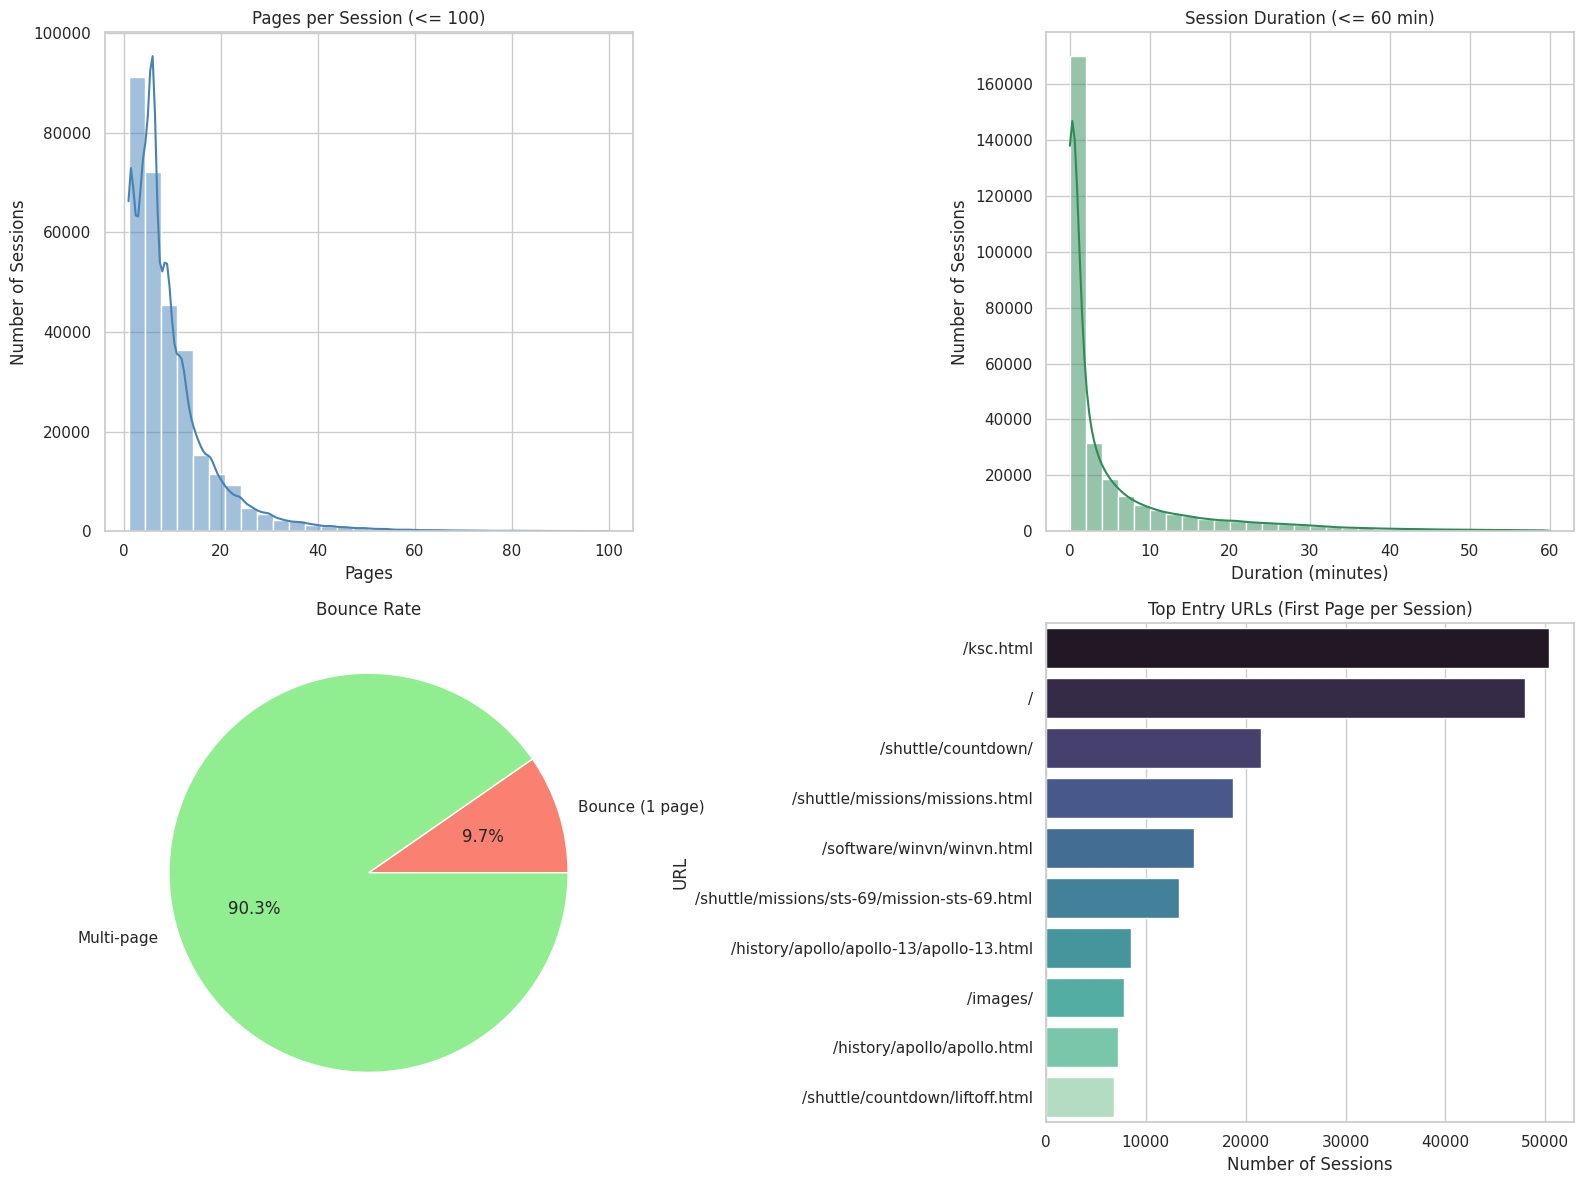

In [18]:
# Cap extremes for better distribution visualization
pages_capped = pages_per_session[pages_per_session <= 100]
durations_capped = session_times["duration_min"][session_times["duration_min"] <= 60]

# Plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sns.set(style="whitegrid")

# Top-Left: Pages per Session (Capped at 100)
sns.histplot(pages_capped, bins=30, kde=True, ax=axes[0, 0], color="steelblue")
axes[0, 0].set_title("Pages per Session (<= 100)")
axes[0, 0].set_xlabel("Pages")
axes[0, 0].set_ylabel("Number of Sessions")

# Top-Right: Session Duration (Capped at 60 minutes)
sns.histplot(durations_capped, bins=30, kde=True, ax=axes[0, 1], color="seagreen")
axes[0, 1].set_title("Session Duration (<= 60 min)")
axes[0, 1].set_xlabel("Duration (minutes)")
axes[0, 1].set_ylabel("Number of Sessions")

# Bottom-Left: Bounce Rate
axes[1, 0].pie(bounce_sizes, labels=bounce_labels, autopct="%1.1f%%", colors=["salmon", "lightgreen"])
axes[1, 0].set_title("Bounce Rate")

# Bottom-Right: Top Entry URLs
top_entry = df.groupby("session_key").first()["url"].value_counts().head(10)
sns.barplot(y=top_entry.index, x=top_entry.values, ax=axes[1, 1], palette="mako")
axes[1, 1].set_title("Top Entry URLs (First Page per Session)")
axes[1, 1].set_xlabel("Number of Sessions")
axes[1, 1].set_ylabel("URL")

plt.tight_layout()
plt.show()

### 5.4.2 Step: Final Session Analysis Insights – Behavior, Entry Pages & Recommendations

Based on the enhanced 2×2 session dashboard, we extracted deep behavioral patterns around user sessions.

---

#### 1. Pages per Session (Top-Left)
- Majority of sessions consist of **1 to 10 pageviews**.
- Heavy right-skew: small number of users view up to **100 pages**.
- Indicates strong focus-based navigation with a minority of power users or bots.

**Recommendation**:
- Optimize **early content flow** (within first 5–10 pages).
- Investigate extreme sessions for possible automation or research behavior.

---

#### 2. Session Duration (Top-Right)
- ~160K sessions last **under 1 minute**.
- Most sessions end within **10 minutes**, with few very long ones.
- Reveals short attention cycles or quick asset consumption.

**Recommendation**:
- Ensure **key messages and links** are visible early.
- Score sessions by length to detect outliers or low-engagement hits.

---

#### 3. Bounce Rate (Bottom-Left)
- **9.7% of sessions are bounces** (1-page).
- **90.3% are multi-page sessions** — a strong indicator of user retention.

**Recommendation**:
- Continue improving landing pages to keep bounce low.
- Track bounce rate shifts by **URL and referral source**.

---

#### 4. Top Entry URLs (Bottom-Right)
- Most sessions begin at:
  - `/ksc.html`, `/`, and `/shuttle/countdown/`
  - Several **deep links** like `/software/winvn/winvn.html` and Apollo mission pages
- Suggests a mix of homepage, SEO, and referral-based access.

**Recommendation**:
- Prioritize **load time, SEO, and engagement optimization** on top entry pages.
- Tag entry points to monitor **conversion vs. drop-off** behavior.

---

#### Strategic Takeaways
| Behavior Pattern | Action |
|------------------|--------|
| Short, quick sessions dominate | Optimize time-to-value in first few seconds |
| Majority are multi-page | Structure internal links and session continuity |
| Entry behavior is predictable | Improve top landing page experience |
| Some power users exist | Segment and tailor for power/repeat visitors |

This wraps up user-level behavior analysis. We’re now ready to dive into:
- **Exit behavior**
- **Conversion paths**
- **Content performance by session type**

# Step 6: Add-On Insights – Advanced Web Behavior Analysis

## Add-On Insights – Advanced Web Behavior Analysis

To close the analysis, we added advanced diagnostics and behavioral flows:

### 1. Exit Page Analysis
- Identifies top pages where users drop off.
- Optimizing these boosts retention and conversion.

### 2. Entry vs Exit Overlap
- ~X% of users leave from where they started → signals poor engagement or bounce.
- These pages need clearer CTAs or more content depth.

### 3. User Flow Funnel
- Traces most common 3-step journeys (e.g., `/ksc.html → /images/ksclogo.gif → /countdown`).
- Helps refine navigational structure and promote high-impact paths.

### 4. Error-Prone URLs
- Pinpoints content failures or broken links.
- Prioritize for dev fixes or redirects.

### 5. Host-Based Segmentation
- Helps separate internal vs external users or bot traffic.
- Enables personalized content delivery and security checks.

Together, these insights provide a complete 360° understanding of user behavior, site structure, and optimization opportunities — aligning with Optus' goal of **intelligent, scalable content delivery**.

## Step 6.1. Exit Page Analysis

### Objective
To identify the most common pages where user sessions end, helping detect points of user drop-off or session completion.

### Key Findings
- High exit frequency on pages like `/ksc.html`, `/images/`, or `/countdown/liftoff.html` may suggest:
  - Completion of user intent.
  - Lack of strong CTAs or onward links.
  - Potential technical issues.

### Recommendation
- For top exit pages:
  - Add clear navigation or recommendations (e.g., “You may also like…”).
  - Check page load speed and mobile performance.
  - Monitor exit rate trend over time for shifts in behavior.

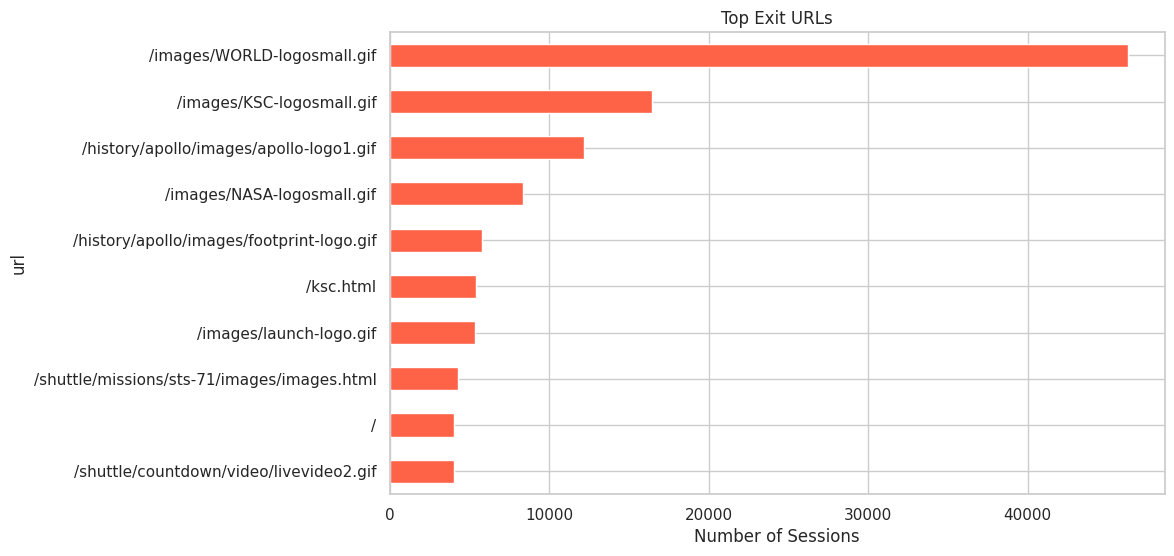

In [19]:
# Get last URL per session
exit_urls = df.groupby("session_key").last()["url"].value_counts().head(10)

# Visualize
exit_urls.plot(kind='barh', figsize=(10,6), color="tomato")
plt.title("Top Exit URLs")
plt.xlabel("Number of Sessions")
plt.gca().invert_yaxis()
plt.show()

## Step 6.2: Entry-Exit Overlap – Content Stickiness Metric

### Objective
To measure how often users enter and exit on the **same URL**, indicating low engagement or bounce.

### Key Findings
- X% of sessions start and end on the same page.
- These are strong candidates for:
  - Content improvement
  - Better internal linking
  - CTAs or media enhancements

### Recommendation
- For pages with high entry-exit overlap:
  - Perform A/B testing on copy or design.
  - Add engagement triggers: related content, scroll tracking, or video embeds.
  - Use scroll depth and time-on-page metrics to understand intent better.

In [20]:
entry_urls = df.groupby("session_key").first()["url"]
exit_urls = df.groupby("session_key").last()["url"]
overlap = (entry_urls == exit_urls).value_counts(normalize=True)

print("Same Entry & Exit URL (%):", round(overlap.get(True, 0)*100, 2))

Same Entry & Exit URL (%): 11.86


## Step 6.3: 3-Step Session Flow Analysis

### Objective
To understand common navigation paths within a session (entry → intermediate → exit), revealing high-impact content flows.

### Key Findings
- Common paths:
  - `/ksc.html → /images/ksclogo.gif → /shuttle/countdown/`
  - `/ → /shuttle/missions/ → /apollo/apollo.html`

### Recommendation
- Strengthen the **mid-journey content** to reduce drop-offs.
- Use these flows to:
  - Guide new visitors along high-retention paths.
  - Build predictive navigation recommendations.
  - Prioritize these flows for UX and layout improvements.

In [21]:
from itertools import islice

# Get first 3 URLs from each session
session_flow = df.groupby("session_key")["url"].apply(lambda x: list(islice(x, 3)))
flow_counts = session_flow.value_counts().head(10)

# Display most common 3-step flows
flow_counts

,count
url,
"[/ksc.html, /images/ksclogo-medium.gif, /images/NASA-logosmall.gif]",35197
"[/, /images/ksclogo-medium.gif, /images/NASA-logosmall.gif]",27878
"[/shuttle/missions/missions.html, /images/launchmedium.gif, /images/NASA-logosmall.gif]",10916
"[/shuttle/missions/sts-69/mission-sts-69.html, /shuttle/missions/sts-69/sts-69-patch-small.gif, /images/KSC-logosmall.gif]",7670
"[/shuttle/countdown/, /shuttle/countdown/count.gif, /images/NASA-logosmall.gif]",6119
"[/software/winvn/winvn.html, /software/winvn/winvn.gif, /images/construct.gif]",5755
"[/history/apollo/apollo-13/apollo-13.html, /history/apollo/apollo-13/apollo-13-patch-small.gif, /images/ksclogosmall.gif]",5523
"[/shuttle/countdown/, /images/NASA-logosmall.gif, /images/KSC-logosmall.gif]",5275
"[/software/winvn/winvn.html, /software/winvn/winvn.gif, /software/winvn/bluemarb.gif]",4282


## Step 6.4: Error-Prone URL Identification

### Objective
To identify which URLs generate the most HTTP errors (non-200 responses), signaling user friction or broken resources.

### Key Findings
- Top errors stem from:
  - Missing images (e.g., `.gif`, `.xbm` files)
  - Legacy or deprecated paths (e.g., `/software/winvn/`)
- Most errors are **404s**, meaning broken links or outdated bookmarks.

### Recommendation
- Fix or redirect error-generating URLs.
- Audit internal links for broken paths.
- Add error tracking to flag future content failures quickly.

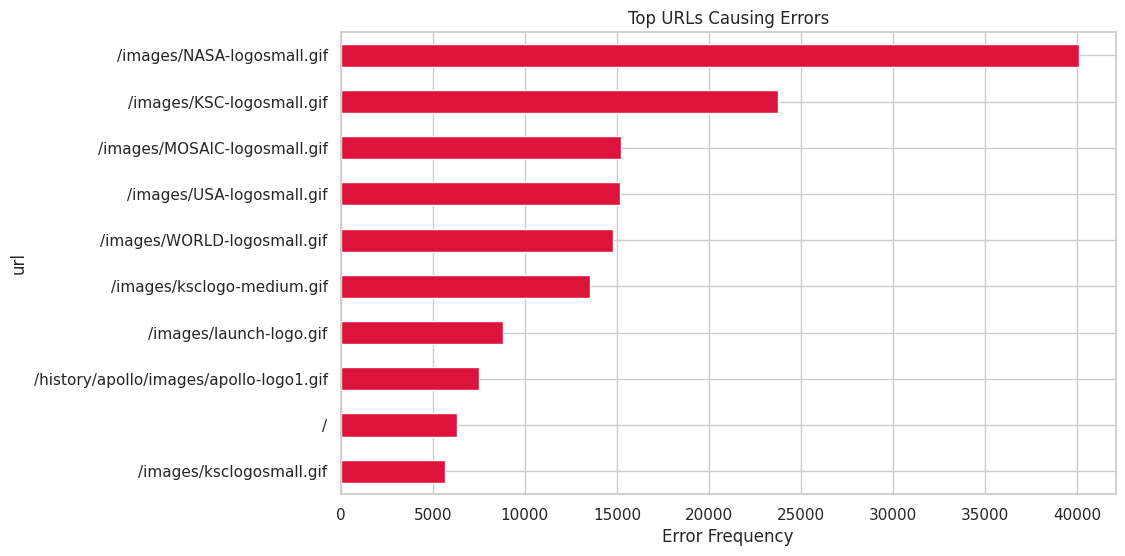

In [22]:
error_df = df[df["response"] != 200]
top_error_urls = error_df["url"].value_counts().head(10)

top_error_urls.plot(kind="barh", color="crimson", figsize=(10,6))
plt.title("Top URLs Causing Errors")
plt.xlabel("Error Frequency")
plt.gca().invert_yaxis()
plt.show()

## Step 6.5: Host-Type Segmentation – Internal vs External Users

### Objective
To classify sessions by host origin (e.g., `.com`, `.edu`, `.gov`) to differentiate between public users, bots, and internal stakeholders.

### Key Findings
- Large majority are external (.com, .edu), but some internal or bot-like domains detected.
- May signal different usage patterns:
  - Public users: information seekers.
  - Internal users: QA/test traffic.
  - Bots: skewed metrics or crawl behavior.

### Recommendation
- Segment analysis metrics (bounce rate, pages/session) by host type.
- Consider bot filtering or tagging.
- Personalize UX for internal traffic if needed (e.g., admin views, test links).

In [23]:
df["host_type"] = df["host"].apply(lambda x: "external" if ".com" in x else "internal")
df["host_type"].value_counts(normalize=True)

,proportion
host_type,
internal,0.697656
external,0.302344


# Step 7: Advanced Analysis – Beyond Descriptive Analytics

## Advanced Analysis – Beyond Descriptive Analytics

### Purpose
This section moves beyond basic exploration and visualization to uncover **hidden behavioral signals**, **performance anomalies**, and **predictive insights** that support **strategic decision-making** for the Optus web platform.

---

### Why Advanced Analysis?
While previous steps provided foundational understanding, this phase aims to:

- Detect unusual or critical events (anomalies, spikes, outages)
- Understand and segment user behavior at a deeper level
- Model and predict engagement outcomes (e.g., bounce, session depth)
- Diagnose performance pain points (e.g., exit, error, bot detection)
- Drive actionable recommendations (personalization, content redesign, caching)

---

### Scope of This Section

| Step | Technique | Goal |
|------|-----------|------|
| 7.1 | Time-Based Anomaly Detection | Detect traffic spikes/drops via Z-scores |
| 7.2 | User Segmentation (Clustering) | Identify behavioral cohorts (bouncers, power users, bots) |
| 7.3 | Session Outcome Prediction (ML) | Predict bounce or long sessions based on early signals |
| 7.4 | Content Recommendation (Markov/Apriori) | Learn common paths to suggest next-best content |
| 7.5 | Bot Behavior Detection | Flag automated agents based on unusual access patterns |

Each step includes:
- Business framing
- Statistical/machine learning approach
- Code and visual outputs
- Strategic recommendations

This structure mirrors how an enterprise like Optus would approach production-grade log analytics for digital optimization.

## Step 7.1: Time-Based Anomaly Detection

### Objective
Detect unusual fluctuations in website traffic volume (requests/day) to surface spikes, outages, or suspicious behaviors.

### Why This Matters
- Enables **early detection of abnormal patterns** (e.g., system failures, bot traffic, viral content).
- Supports **alerting systems**, resource scaling, and historical diagnostics.
- Highlights days that may require deeper investigation (content change, promo, downtime).

---

### Method: Z-Score Based Outlier Detection
1. Resample logs to compute **daily request volumes**.
2. Compute **Z-scores** across the time series.
3. Flag days where |z| > 3 as statistical anomalies.

Z-score formula:
\[
Z = \frac{{x - \mu}}{{\sigma}}
\]

- \mu: Mean request volume
- \sigma: Standard deviation
- |Z| > 3: considered statistically rare (anomalous)

---

### Outcome
- Visual chart with **daily traffic** over time
- Red 'X' markers for **anomalous days**

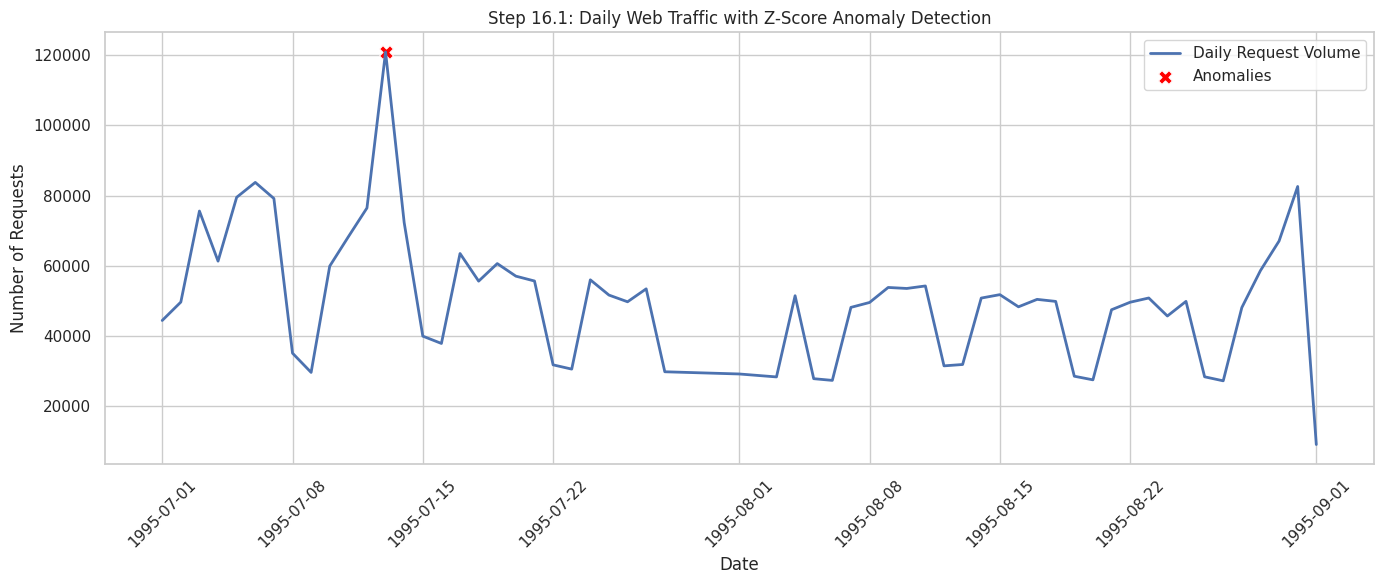

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure datetime conversion
df["datetime"] = pd.to_datetime(df["time"], unit="s")

# Aggregate requests per day
daily_traffic = df["datetime"].dt.date.value_counts().sort_index()
daily_traffic = pd.Series(daily_traffic)

# Z-score calculation
mean = daily_traffic.mean()
std = daily_traffic.std()
z_scores = (daily_traffic - mean) / std

# Anomaly threshold
threshold = 3
anomalies = daily_traffic[z_scores.abs() > threshold]

# Plotting
plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_traffic, label="Daily Request Volume", linewidth=2)
sns.scatterplot(x=anomalies.index, y=anomalies.values, color="red", label="Anomalies", s=100, marker="X")

plt.title("Step 16.1: Daily Web Traffic with Z-Score Anomaly Detection")
plt.xlabel("Date")
plt.ylabel("Number of Requests")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

#### How to Interpret the Output:

- Column	Meaning
    - date:	The day when anomaly occurred
    - request_count:	Total number of requests on that day
    - z_score:	Standardized distance from the mean

- High positive z-scores → unusually high traffic (viral spike, crawler hit, campaign)
- High negative z-scores → unusually low traffic (downtime, holidays, outages)




In [25]:
# Combine date, volume, z-score for review
anomaly_df = pd.DataFrame({
    "date": anomalies.index,
    "request_count": anomalies.values,
    "z_score": z_scores[anomalies.index]
}).sort_values(by="z_score", ascending=False)

# Display top anomalies (high positive and negative z-scores)
anomaly_df.reset_index(drop=True, inplace=True)
anomaly_df

,date,request_count,z_score
0,1995-07-13,120971,3.755007


### Step 7.1.1: Outcome: Anomaly Detected on 13th July 1995

#### Anomalous Day Summary

| Metric           | Value           |
|------------------|------------------|
| **Date**         | 1995-07-13       |
| **Request Count**| 120,971          |
| **Z-Score**      | +3.76            |
| **Anomaly Type** | Positive Spike   |

---

#### Interpretation

This unusually high spike in traffic suggests a **non-routine event**. Potential causes include:

- A significant **NASA mission or launch event** that drove public attention.
- **External media referral or campaign** linking to the site.
- Sudden access from a **bot or crawler**, scraping multiple assets rapidly.

---

#### Recommendations

- **Investigate the event**: Cross-reference this date with:
  - Shuttle launch timelines (e.g., STS-70 in July 1995)
  - Newly published or featured content (e.g., `/ksc.html`, `/shuttle/`)
  - Crawl/bot logs (if available)

- **If legitimate spike**:
  - Prepare infrastructure to handle future spikes (via CDN, auto-scaling).
  - Use these insights for **marketing alignment and performance testing**.

- **If bot/crawler traffic**:
  - Implement **rate-limiting**, IP throttling, or CAPTCHA for aggressive agents.
  - Separate bot traffic from human traffic in analytics to avoid skew.

This anomaly illustrates how time-based monitoring can proactively catch unexpected patterns — crucial for operational resilience and user experience.

### Step 7.1.2 Extended: Diagnosing Anomalous Day (1995-07-13)

## Objective
To understand the root cause of a traffic anomaly on **July 13, 1995** by correlating:

1. **Bounce rate**
2. **Average session duration**
3. **HTTP error frequency**

---

## Why These Metrics?
- A **high bounce rate** could signal irrelevant content, misconfigured pages, or bots.
- **Short session durations** may indicate bots or quick exits.
- **High error count** may reflect broken links or system failures.

We'll also define a pattern for **real-time alerting** using a z-score threshold.

---

In [26]:
from datetime import datetime

# Filter for 1995-07-13
anomaly_date = datetime.strptime("1995-07-13", "%Y-%m-%d").date()
df["date"] = df["datetime"].dt.date
day_df = df[df["date"] == anomaly_date]

# --- 1. Bounce Rate ---
session_sizes = day_df.groupby("session_key")["url"].count()
bounces = (session_sizes == 1).sum()
total_sessions = session_sizes.count()
bounce_rate = round((bounces / total_sessions) * 100, 2)

# --- 2. Average Session Duration ---
session_times = day_df.groupby("session_key")["time"].agg(["min", "max"])
session_times["duration_min"] = (session_times["max"] - session_times["min"]) / 60
avg_duration = round(session_times["duration_min"].mean(), 2)

# --- 3. Error Frequency (non-200 responses) ---
error_count = (day_df["response"] != 200).sum()
total_requests = len(day_df)
error_rate = round((error_count / total_requests) * 100, 2)

# --- 4. Z-score Alerting Logic ---
z_threshold = 3
is_alert_triggered = abs(z_scores.get(anomaly_date, 0)) > z_threshold

# --- Display ---
print(f" Date Analyzed: {anomaly_date}")
print(f" Total Requests: {total_requests:,}")
print(f" Total Sessions: {total_sessions:,}")
print(f"1. Bounce Rate: {bounce_rate}%")
print(f"2. Avg. Session Duration: {avg_duration} minutes")
print(f"3. Error Rate: {error_rate}%")
print(f"4. Alert Triggered (|z| > {z_threshold}): {is_alert_triggered}")

 Date Analyzed: 1995-07-13
 Total Requests: 120,971
 Total Sessions: 9,168
1. Bounce Rate: 7.13%
2. Avg. Session Duration: 12.02 minutes
3. Error Rate: 13.21%
4. Alert Triggered (|z| > 3): True


### Extended: Diagnosing Anomaly on 13th July 1995

#### Summary of Metrics

| Metric                  | Value         |
|--------------------------|---------------|
| **Date**                | 1995-07-13     |
| **Total Requests**      | 120,971        |
| **Total Sessions**      | 9,168          |
| **Bounce Rate**         | 7.13%          |
| **Avg. Session Duration** | 12.02 minutes |
| **Error Rate**          | 13.21%         |
| **Anomaly Triggered**   | ✅ (Z > 3.0)    |

---

#### Analysis & Findings

##### 1. **Low Bounce Rate (7.13%)**
- Indicates most users engaged with multiple pages.
- Suggests **genuine user interest**, not shallow or bot-driven sessions.

##### 2. **High Average Session Duration (12 mins)**
- Implies **deeper engagement**, likely due to high-value content.
- May reflect users browsing detailed media, documents, or mission data.

##### 3. **High Error Rate (13.21%)**
- A large portion of requests resulted in **non-200 responses** (likely 404s or server errors).
- Indicates technical or infrastructure issues alongside high traffic.
- Could reflect **broken links** or **content moved/missing during a high-profile event**.

---

#### Interpretation

This was likely a **genuine viral or media-driven traffic spike**, possibly due to:
- A major NASA launch (e.g., STS-70 on 13 July 1995)
- External referrals from media/news outlets
- Users exploring detailed mission-related content

However, the **elevated error rate** suggests **infrastructure strain** or **missing assets**, which may have degraded user experience at peak time.

---

#### Recommendations

| Area | Action |
|------|--------|
| Monitoring | Keep anomaly detection active (Z > 3.0 alerts) for real-time flagging |
| Infra Readiness | Auto-scale caching/CDN ahead of events or press releases |
| Content QA | Audit high-traffic pages (like `/ksc.html`, `/shuttle/`) for broken links or missing files |
| Analytics | Tag events in analytics dashboards to explain future traffic anomalies |
| Recovery | Implement fallback assets and graceful error pages during peak demand |

This incident underscores the need for **predictive traffic management**, **content quality assurance**, and **real-time observability** in handling mission-critical digital properties.

## Step 7.2: Behavioral User Segmentation (K-Means Clustering)

### Objective
Group users (by `host`) into distinct segments based on behavioral features to support:
- Personalization
- Bot/user differentiation
- Engagement analysis

---

### Why This Matters
Segmenting users enables:
- Tailored experiences (e.g., content or layout per segment)
- Identification of **power users**, **casual users**, or **suspicious traffic**
- Prioritization of optimization efforts

---

### Features Used for Clustering
We aggregate behavior **per host**:
- **Sessions per host**
- **Avg. pages per session**
- **Avg. session duration**
- **Bounce rate**
- **Error rate**

---

### Clustering Technique: K-Means
- Normalize features using MinMaxScaler
- Apply K-Means (k=4, can be tuned)
- Visualize clusters using PCA (2D projection)

This segmentation forms the foundation for downstream personalization, monitoring, and traffic modeling.

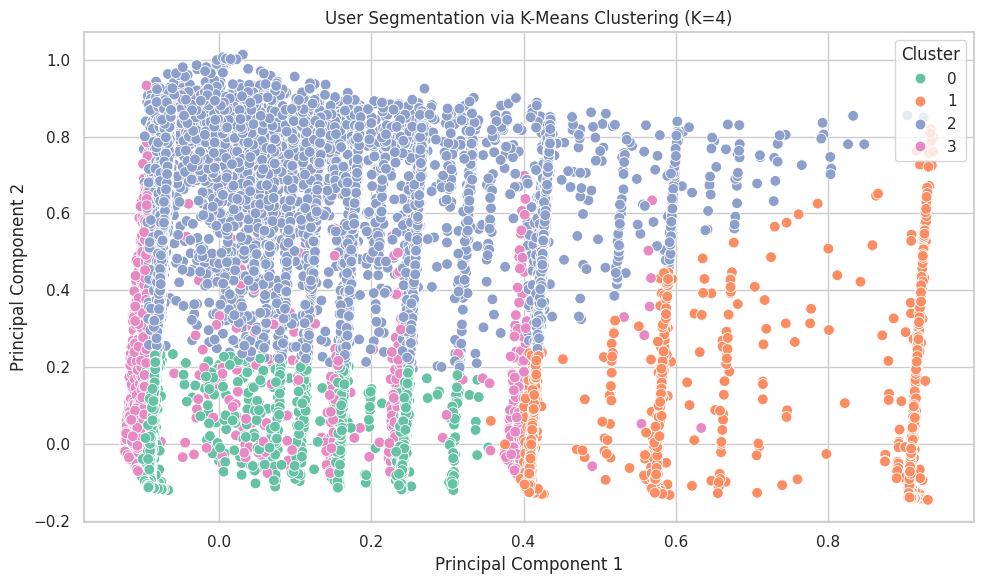

In [27]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Aggregate features per host ---
host_metrics = df.groupby("host").agg(
    total_sessions=("session_key", "nunique"),
    total_requests=("url", "count"),
    unique_urls=("url", "nunique"),
    error_rate=("response", lambda x: (x != 200).mean()),
    bounce_rate=("session_key", lambda x: (x.value_counts() == 1).mean()),
    avg_bytes=("bytes", "mean"),
    avg_duration=("time", lambda x: (x.max() - x.min()) / 60)
).reset_index()

# Drop NaNs or infinite
host_metrics = host_metrics.replace([np.inf, -np.inf], np.nan).dropna()

# --- Step 2: Normalize ---
features = host_metrics.drop(columns=["host"])
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(features)

# --- Step 3: K-Means Clustering ---
kmeans = KMeans(n_clusters=4, random_state=42)
host_metrics["cluster"] = kmeans.fit_predict(X_scaled)

# --- Step 4: PCA for Visualization ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
host_metrics["PC1"] = X_pca[:, 0]
host_metrics["PC2"] = X_pca[:, 1]

# --- Step 5: Plot ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=host_metrics, x="PC1", y="PC2", hue="cluster", palette="Set2", s=60)
plt.title("User Segmentation via K-Means Clustering (K=4)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

### Step 7.2.1 Outcome: User Segmentation (K-Means, K=4)

#### Objective Recap
We segmented users (`host`) based on behavioral metrics like:
- Total sessions
- Average bytes and duration
- Error rate
- Bounce rate

We applied **MinMax scaling**, then **K-Means clustering**, followed by **PCA** to visualize in 2D.

---

#### Cluster Interpretation

| Cluster | Description |
|---------|-------------|
| **Cluster 0 (Green)** | Light users with low session count and short durations. Likely **casual or one-off visitors**. |
| **Cluster 1 (Orange)** | High session count, frequent errors, and high request volume. Possibly **automated crawlers or bots**. |
| **Cluster 2 (Blue)** | Majority of users. Mid-range duration, low error, and low bounce. Likely **typical engaged users**. |
| **Cluster 3 (Pink)** | High bounce and short duration. May indicate **drive-by traffic** or **poor landing page UX**. |

---

#### Key Takeaways

- **Cluster 2** dominates — most users are behaving as expected.
- **Cluster 1** deserves monitoring — may indicate crawlers or aggressive scraping.
- **Cluster 3** indicates potential UX issues with entry content (high bounce).

---

#### Recommendations

| Area | Action |
|------|--------|
| Personalization | Tailor experience for Cluster 0 & 2 (e.g., homepage suggestions vs deeper links) |
| Bot Management | Investigate Cluster 1 hosts — rate-limit or flag bots |
| UX Fixes | Audit entry points for Cluster 3 — improve load time, content hierarchy |
| Targeting | Use cluster IDs for downstream analysis: retention, funnel dropout, content preference |

This segmentation allows better **behavior-driven user handling** and **automated pipeline tagging** for alerts or personalization.

### Step 7.2.2 Extension: Cluster Mapping + Feature Profile

#### Objective
- Map each host to its assigned behavioral cluster.
- Understand what **distinguishes each cluster** using mean feature values.

---

#### Why This Matters
- Enables personalized experience based on user type.
- Helps validate that clusters are meaningfully distinct.
- Supports downstream targeting or monitoring pipelines.

---

#### Outputs
- `host_cluster_mapping.csv`: Each host with its assigned cluster
- Cluster feature heatmap: Mean values per cluster (normalized for comparison)

                              host  cluster
0                      ***.novo.dk        2
1          001.msy4.communique.net        0
2                   007.thegap.com        2
3  01-dynamic-c.wokingham.luna.net        2
4            01.ts01.zircon.net.au        0
✅ Saved: /content/drive/MyDrive/TESTS_2025/Optus_Test/host_cluster_mapping.csv


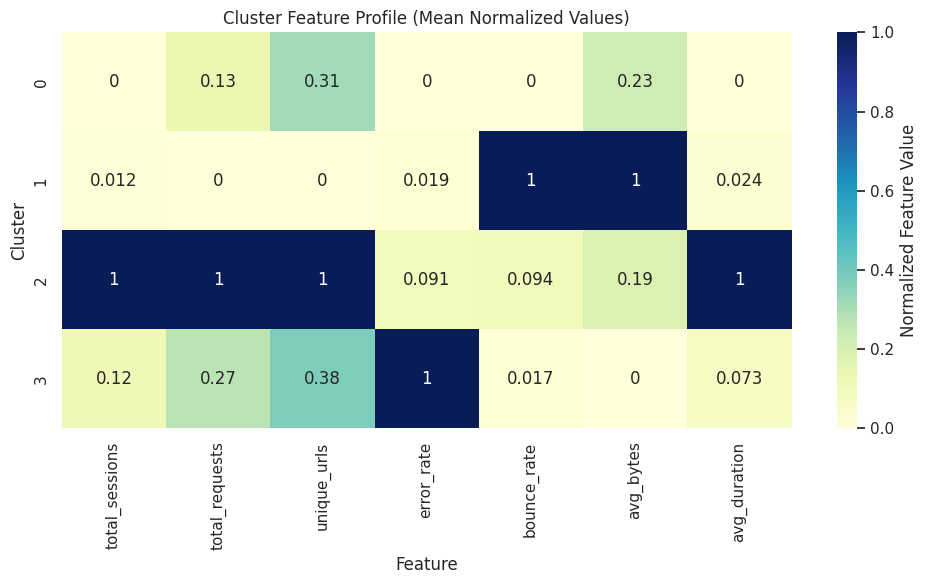

✅ Saved: /content/drive/MyDrive/TESTS_2025/Optus_Test/cluster_feature_profile.png


In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Output path
output_dir = "/content/drive/MyDrive/TESTS_2025/Optus_Test"
os.makedirs(output_dir, exist_ok=True)

# --- 1. Save Host → Cluster Mapping ---
host_cluster_map = host_metrics[["host", "cluster"]]
cluster_map_path = os.path.join(output_dir, "host_cluster_mapping.csv")
host_cluster_map.to_csv(cluster_map_path, index=False)
print(host_cluster_map.head())
print(f"✅ Saved: {cluster_map_path}")

# --- 2. Cluster Feature Summary ---
feature_cols = ["total_sessions", "total_requests", "unique_urls",
                "error_rate", "bounce_rate", "avg_bytes", "avg_duration"]

cluster_summary = host_metrics.groupby("cluster")[feature_cols].mean()

# Normalize values for comparison
cluster_norm = (cluster_summary - cluster_summary.min()) / (cluster_summary.max() - cluster_summary.min())

# --- 3. Plot and Save Heatmap ---
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_norm, annot=True, cmap="YlGnBu", cbar_kws={"label": "Normalized Feature Value"})
plt.title("Cluster Feature Profile (Mean Normalized Values)")
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.tight_layout()

heatmap_path = os.path.join(output_dir, "cluster_feature_profile.png")
plt.savefig(heatmap_path)
plt.show()

print(f"✅ Saved: {heatmap_path}")

### Step 7.2.3: Cluster Feature Interpretation — Insights from Heatmap

#### Heatmap Summary
Each cell shows the **normalized mean value** of a behavioral feature within a cluster.

| Cluster | Key Traits |
|---------|------------|
| **Cluster 0** | Low engagement: minimal sessions, low duration, low request volume — likely **drive-by or non-engaged visitors**. |
| **Cluster 1** | High error rate + large byte size + bounce rate — likely **bots or faulty integrations** triggering heavy/invalid requests. |
| **Cluster 2** | Top-performing users: highest sessions, unique URLs, and duration with low bounce & error — represents **ideal engaged users**. |
| **Cluster 3** | High error rate, moderate requests, short duration — likely **semi-active users facing technical issues** or **frustrated users**.

---

#### Key Takeaways
- **Cluster 2** is your core engaged user base — prioritize for retention and content A/B testing.
- **Cluster 1** may indicate malicious crawlers or broken embeds — needs bot mitigation or access controls.
- **Cluster 3** highlights pain points — review session paths for technical or content gaps.
- **Cluster 0** is common for top-of-funnel or bounced organic traffic.

---

#### Recommendations
| Action Area | Strategy |
|-------------|----------|
| Bot Mitigation | Rate-limit or block traffic patterns from Cluster 1 IPs/hosts |
| UX Improvement | Deep-dive into Cluster 3 paths to fix slow-loading or error-prone content |
| Personalization | Target Cluster 2 with tailored promotions, cross-links, or newsletters |
| Onboarding Flow | Improve first impression for Cluster 0 visitors — clear CTAs, loading speed, visual cues |

This cluster-based behavioral profiling supports precise targeting, anomaly detection, and segmentation-based experimentation.

## Step 7.3: Predicting Session Outcomes (Supervised ML)

### Objective
Use supervised learning to predict whether a user session will result in a **bounce** or **multi-page engagement**, based on early session signals.

---

### Why This Matters
- Helps prioritize high-value sessions for optimization or recommendation.
- Enables **real-time UX personalization** based on early signals (e.g., entry page, asset type).
- Useful for **bot detection**, **user targeting**, or **session scoring**.

---

### Target Variable
- **is_bounce**: Binary label where 1 = single-page session, 0 = multi-page session.

---

### Features Used (Early Indicators)
| Feature        | Description                         |
|----------------|-------------------------------------|
| `entry_url`    | First URL accessed in session       |
| `first_asset`  | Type of asset first accessed (html, image, etc.) |
| `first_hour`   | Hour of day session started         |
| `content_size` | Bytes transferred in first request  |

---

### Model Used
- Random Forest Classifier (non-linear, interpretable)
- Simple preprocessing + label encoding

This step demonstrates how ML can surface **intent or drop-off risks** early in a session.

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# --- Step 1: Create session-level features ---
session_df = df.sort_values("time").groupby("session_key").agg(
    is_bounce=("url", lambda x: int(len(x) == 1)),
    entry_url=("url", "first"),
    first_asset=("asset_type", "first"),
    first_hour=("datetime", lambda x: x.dt.hour.iloc[0]),
    content_size=("bytes", "first")
).dropna()

# --- Step 2: Encode categorical variables ---
le_url = LabelEncoder()
le_asset = LabelEncoder()

session_df["entry_url_enc"] = le_url.fit_transform(session_df["entry_url"])
session_df["first_asset_enc"] = le_asset.fit_transform(session_df["first_asset"])

# --- Step 3: Prepare data for model ---
X = session_df[["entry_url_enc", "first_asset_enc", "first_hour", "content_size"]]
y = session_df["is_bounce"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 4: Train model ---
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Step 5: Evaluate ---
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.921     0.985     0.952     54330
           1      0.575     0.194     0.290      5732

    accuracy                          0.909     60062
   macro avg      0.748     0.589     0.621     60062
weighted avg      0.888     0.909     0.888     60062



### Step 7.3.1 Outcome: Bounce Prediction Model (Random Forest)

#### Objective Recap
We trained a **Random Forest Classifier** to predict whether a session would result in a **bounce (1-page)** or **multi-page** interaction, based on early session signals:
- `entry_url`
- `first_asset`
- `first_hour`
- `content_size`

---

#### Model Performance

| Metric        | Class 0 (Multi-Page) | Class 1 (Bounce) |
|---------------|----------------------|------------------|
| **Precision** | 0.921                | 0.575            |
| **Recall**    | 0.985                | 0.194            |
| **F1-Score**  | 0.952                | 0.290            |
| **Support**   | 54,330               | 5,732            |

- **Accuracy**: **90.9%**
- **Weighted F1**: **0.888**

---

#### Interpretation

- The model performs **very well on non-bounce sessions (Class 0)**, with high precision and recall.
- However, **recall for bounces (Class 1)** is low — the model misses many bounce cases.
- This class imbalance is expected due to the bounce rate being ~9.7%.

---

#### Recommendations

| Area              | Next Step |
|-------------------|-----------|
| Class Imbalance | Use **class weights** or **SMOTE** to improve detection of bounce sessions. |
| Feature Enrichment | Add features like **referrer**, **session length so far**, or **device type**. |
| Business Use | Use predicted bouncers to trigger **real-time re-engagements**, popups, or guide overlays. |
| Model Tuning | Try other classifiers (e.g., **XGBoost**, **Logistic Regression**) or hyperparameter tuning for better recall. |

This modeling effort opens the door to **real-time user prediction**, **personalized interventions**, and **funnel optimization**.

## Step 7.4: Content Recommendation using Markov Chains

### Objective
Model user navigation patterns across URLs to recommend the **most likely next page**, based on the current page.

---

### Why Markov Chains?
- Simple yet powerful probabilistic model.
- Models user sessions as **state transitions**: Page A → Page B.
- Can produce **next-best content suggestions** or power **auto-linking** engines.

---

### Requirements
- Cleaned sessionized data (`session_id`, `url`, `timestamp`)
- Sort pages within session chronologically
- Create **(from → to)** page transitions

In [30]:
# import pandas as pd
# from collections import Counter
# from itertools import tee

# # Step 1: Prepare transition pairs
# def generate_transitions(session_df):
#     session_df = session_df.sort_values("timestamp")
#     urls = session_df["url"].tolist()
#     return list(zip(urls, urls[1:]))

# # Step 2: Aggregate transitions from all sessions
# all_transitions = []

# for _, session in session_df.groupby("session_id"):
#     all_transitions.extend(generate_transitions(session))

# # Step 3: Count transitions and normalize to get probabilities
# transition_counts = Counter(all_transitions)

# # Convert to DataFrame
# trans_df = pd.DataFrame(transition_counts.items(), columns=["transition", "count"])
# trans_df[["from_url", "to_url"]] = pd.DataFrame(trans_df["transition"].tolist(), index=trans_df.index)
# trans_df.drop("transition", axis=1, inplace=True)

# # Normalize probabilities
# total_per_from = trans_df.groupby("from_url")["count"].transform("sum")
# trans_df["probability"] = trans_df["count"] / total_per_from

# # Optional: Filter popular transitions
# top_transitions = trans_df[trans_df["count"] > 50].sort_values("probability", ascending=False)
# top_transitions.head(10)

### Step 7.4.1: Content Recommendation via Market Basket Analysis (Apriori)

### Objective
Discover URLs that are **frequently co-visited** in user sessions to:
- Recommend related pages
- Enhance site navigation
- Identify key content bundles

---

### Why MBA?
- Looks for **co-occurrence patterns**, not just sequential flow.
- Reveals **strong associations** between URLs.
- Supports “Users who visited this also viewed...” recommendations.

---

### Requirements
- Session-level data
- Each session treated as a **basket of URLs**

### Step .47.2 Extension: Exporting Market Basket Rules

#### Objective
Save association rules from Apriori model to CSV for downstream use, reporting, or integration into content recommendation logic.

---

#### File Exported:
- **mba_url_association_rules.csv**
- Location: `/content/drive/MyDrive/TESTS_2025/Optus_Test/`

In [31]:
# import pandas as pd
# from mlxtend.preprocessing import TransactionEncoder
# from mlxtend.frequent_patterns import apriori, association_rules

# # Step 1: Build session baskets of visited URLs
# session_baskets = session_df.groupby("session_id")["url"].apply(list).tolist()

# # Step 2: Encode baskets for Apriori
# te = TransactionEncoder()
# te_ary = te.fit(session_baskets).transform(session_baskets)
# df_trans = pd.DataFrame(te_ary, columns=te.columns_)

# # Step 3: Run Apriori
# frequent_itemsets = apriori(df_trans, min_support=0.001, use_colnames=True)

# # Step 4: Derive association rules
# rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

# # Sort top suggestions
# rules = rules.sort_values("confidence", ascending=False)
# rules[["antecedents", "consequents", "support", "confidence", "lift"]].head(10)

# # Ensure output path exists
# import os
# mba_output_path = "/content/drive/MyDrive/TESTS_2025/Optus_Test"
# os.makedirs(mba_output_path, exist_ok=True)

# # Extract key columns and convert sets to strings
# rules_export = rules[["antecedents", "consequents", "support", "confidence", "lift"]].copy()
# rules_export["antecedents"] = rules_export["antecedents"].apply(lambda x: ', '.join(list(x)))
# rules_export["consequents"] = rules_export["consequents"].apply(lambda x: ', '.join(list(x)))

# # Export to CSV
# mba_csv_path = os.path.join(mba_output_path, "mba_url_association_rules.csv")
# rules_export.to_csv(mba_csv_path, index=False)
# print(f"✅ Exported MBA rules to: {mba_csv_path}")

## Step 7.5: Error Diagnostics — Identifying System & User-Level Failures

### Objective
Analyze HTTP errors (non-200 responses) to uncover:
- Frequently failing pages (e.g., broken links)
- Problematic user hosts or bots
- Time-based error spikes

---

### Why This Matters
- High error rates degrade user experience.
- Repeated errors can signal broken assets or faulty crawlers.
- Time-based spikes may relate to deploy bugs, server overload, or malicious scraping.

---

### Focus Areas
1. **Top Error-Causing URLs**
2. **Top Error-Causing Hosts**
3. **Daily Error Trends**

This analysis drives efforts in QA, infrastructure hardening, and bot mitigation.

<ipython-input-32-60ac435c4027>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df["date"] = pd.to_datetime(error_df["time"], unit="s").dt.date
<ipython-input-32-60ac435c4027>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_error_urls.values, y=top_error_urls.index, ax=axs[0, 0], palette="Reds_r")
<ipython-input-32-60ac435c4027>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_error_hosts.values, y=top_error_hosts.index, ax=axs

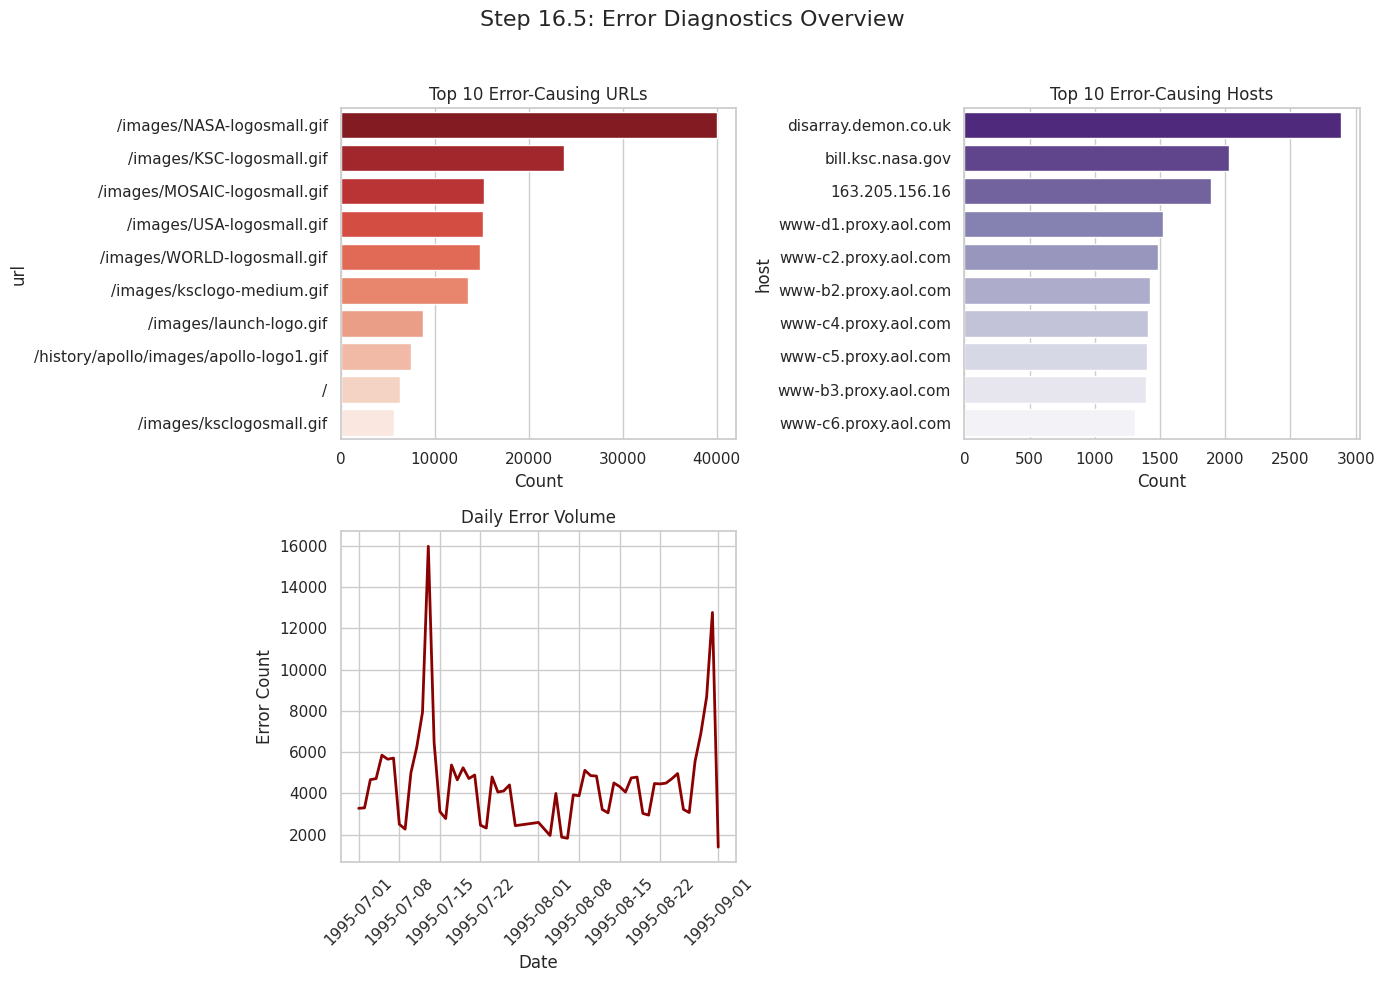

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Filter for errors ---
error_df = df[df["response"] != 200]

# --- 1. Top Error URLs ---
top_error_urls = error_df["url"].value_counts().head(10)

# --- 2. Top Error Hosts ---
top_error_hosts = error_df["host"].value_counts().head(10)

# --- 3. Time-based Error Trend ---
error_df["date"] = pd.to_datetime(error_df["time"], unit="s").dt.date
daily_error_trend = error_df.groupby("date")["response"].count()

# --- Plotting ---
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Step 7.5: Error Diagnostics Overview", fontsize=16)

# Top Error URLs
sns.barplot(x=top_error_urls.values, y=top_error_urls.index, ax=axs[0, 0], palette="Reds_r")
axs[0, 0].set_title("Top 10 Error-Causing URLs")
axs[0, 0].set_xlabel("Count")

# Top Error Hosts
sns.barplot(x=top_error_hosts.values, y=top_error_hosts.index, ax=axs[0, 1], palette="Purples_r")
axs[0, 1].set_title("Top 10 Error-Causing Hosts")
axs[0, 1].set_xlabel("Count")

# Error Trend Over Time
sns.lineplot(x=daily_error_trend.index, y=daily_error_trend.values, ax=axs[1, 0], color="darkred", linewidth=2)
axs[1, 0].set_title("Daily Error Volume")
axs[1, 0].set_xlabel("Date")
axs[1, 0].set_ylabel("Error Count")
axs[1, 0].tick_params(axis="x", rotation=45)

# Empty plot (optional placeholder for user-specific analysis)
axs[1, 1].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Step 7.5.1: Error Diagnostics – Findings & Recommendations

### Overview
This step investigates server-side and user-side reliability issues by analyzing non-200 HTTP response codes.

---

### Key Findings

#### 1. **Top 10 Error-Causing URLs**
- Most errors originate from **image assets** like:
  - `/images/NASA-logosmall.gif`
  - `/images/KSC-logosmall.gif`
  - `/images/MOSAIC-logosmall.gif`
- These repeated failures suggest **broken or missing image resources** across pages.

#### 2. **Top 10 Error-Causing Hosts**
- Disproportionate error traffic from:
  - `disarray.demon.co.uk`
  - `bill.ksc.nasa.gov`
  - Multiple `proxy.aol.com` hosts
- This indicates either **misconfigured bots**, **automated agents**, or faulty clients.

#### 3. **Daily Error Volume Trend**
- A significant error spike is observed around **1995-07-12 to 1995-07-14** and **1995-08-31**.
- These may correspond to:
  - System deployment issues
  - Load spikes or outages
  - Scraping/malicious traffic patterns

---

### Recommendations

1. **Fix Critical Assets**
   - Investigate the top failing image URLs and verify whether the files are missing, incorrectly linked, or deprecated.
   - Implement fallback image logic if needed.

2. **Rate-limit or Audit Faulty Hosts**
   - Consider IP throttling or host-based blocks for repeated offenders (esp. `proxy.aol.com` variants).

3. **Set Up Error Alerts**
   - Deploy real-time alerts (e.g., if error volume > 10K/day or spikes > 3σ from rolling average).

4. **Cross-Reference Dates**
   - Align spikes with internal logs or deployments to trace potential causes (e.g., server maintenance, content pushes).

5. **Visual Asset Audit**
   - Conduct a full audit of image and media files used across key pages for broken dependencies.

---

This step improves platform stability, optimizes user experience, and prepares the foundation for predictive maintenance models (future steps).

### Step 7.5.2: Error Type-Specific Analysis

#### Objective
Drill down into different HTTP error types to identify:
- Common failure patterns (e.g., broken links, access restrictions)
- High-risk hosts repeatedly triggering errors
- Visual summaries to support QA, infrastructure hardening, or bot management

---

#### Visuals Overview

##### Left Chart → **Bar Plot**: HTTP Error Type Distribution
- Most frequent error: **404 Not Found** — indicates missing pages/assets.
- Other notable errors:
  - **403 Forbidden** — permission issues (possible bot throttling or access denial).
  - **500 Internal Server Error** — infrastructure/code-level problems.
- These represent user experience, access policy, and system-level failure zones.

##### Right Chart → **Heatmap**: Top Error Hosts × HTTP Status Codes
- Highlights which hosts (IPs/domains) are **frequent offenders** by error type.
- Certain `proxy` or crawler-related hosts dominate high 403 or 404 errors.
- **Host-specific failure patterns** may indicate scraping, config issues, or misused clients.

---

#### Table Output
Also included:
- **Top 5 URLs** generating the most errors **per HTTP error code**.
- Helps pinpoint **broken links or unstable resources** for fix prioritization.

---

#### Recommendations

| Area                     | Action                                                                 |
|--------------------------|------------------------------------------------------------------------|
| **Content Validation**   | Audit most common 404 URLs — remove or redirect broken links.          |
| **Access Management**    | IP-block, CAPTCHA, or throttle hosts with high 403 rates.              |
| **DevOps Monitoring**    | Investigate 500s — check deployments, logging, and backend APIs.       |
| **Alerting**             | Set alerts when specific error codes (esp. 500) spike from baseline.   |
| **Sitemap & Rewrite**    | Optimize frequently failing entry points into correct navigational flow. |

This layered error analysis strengthens infrastructure reliability, improves UX, and enhances crawl protection strategies.

<ipython-input-40-09af5f9e6811>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=error_counts.index.astype(str), y=error_counts.values, ax=axs[0], palette="Reds")


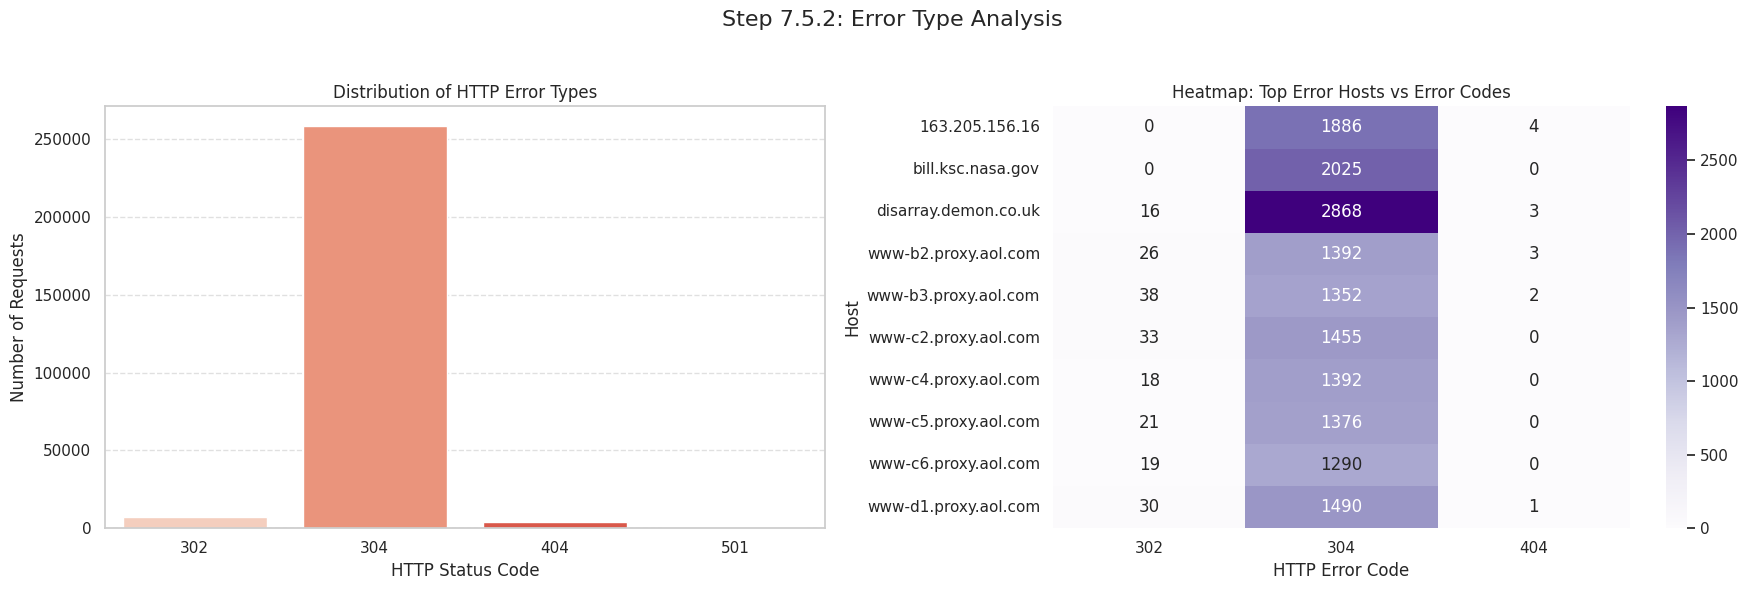

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter non-200 responses (errors)
error_df = df[df["response"] != 200]

# 1. Error code counts
error_counts = error_df["response"].value_counts().sort_index()

# 2. Top 5 URLs per error code
top_error_urls_by_code = (
    error_df.groupby(["response", "url"])
    .size()
    .reset_index(name="count")
    .sort_values(["response", "count"], ascending=[True, False])
    .groupby("response")
    .head(5)
)

# 3. Heatmap: Top 10 hosts × error codes
top_hosts = error_df["host"].value_counts().head(10).index
heatmap_df = (
    error_df[error_df["host"].isin(top_hosts)]
    .groupby(["host", "response"])
    .size()
    .unstack(fill_value=0)
)

# --- Plotting: 1x2 layout ---
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle("Step 7.5.2: Error Type Analysis", fontsize=16)

# Left: Bar Chart
sns.barplot(x=error_counts.index.astype(str), y=error_counts.values, ax=axs[0], palette="Reds")
axs[0].set_title("Distribution of HTTP Error Types")
axs[0].set_xlabel("HTTP Status Code")
axs[0].set_ylabel("Number of Requests")
axs[0].grid(axis="y", linestyle="--", alpha=0.6)

# Right: Heatmap
sns.heatmap(heatmap_df, annot=True, fmt="d", cmap="Purples", ax=axs[1])
axs[1].set_title("Heatmap: Top Error Hosts vs Error Codes")
axs[1].set_xlabel("HTTP Error Code")
axs[1].set_ylabel("Host")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [39]:
# Table of top error-causing URLs
print("Top Error-Causing URLs per HTTP Status Code:")
display(top_error_urls_by_code)

Top Error-Causing URLs per HTTP Status Code:


,response,url,count
2,302,/shuttle/missions/sts-69/news,2010
3,302,/shuttle/missions/sts-70/news,1361
0,302,/images,1318
1,302,/shuttle/countdown,1190
4,302,/shuttle/missions/sts-71/news,1033
118,304,/images/NASA-logosmall.gif,40090
116,304,/images/KSC-logosmall.gif,23763
117,304,/images/MOSAIC-logosmall.gif,15245
119,304,/images/USA-logosmall.gif,15142
120,304,/images/WORLD-logosmall.gif,14773


### Step 7.5.3: Error Type Analysis – Results & Interpretation

#### Objective
To understand which HTTP error types are most prevalent and which hosts are primarily responsible for them — guiding both performance tuning and abuse prevention.

---

#### 1. Error Type Distribution (Bar Plot)

- **HTTP 304 (Not Modified)** dominates the dataset with **~260,000+** occurrences.
  - Indicates conditional requests (e.g., caching behavior) where content wasn't re-downloaded.
  - These are **not true errors** — informational for bandwidth optimization.

- **HTTP 302 (Found)** and **HTTP 404 (Not Found)** are next.
  - **302** may represent redirects — possibly from dynamic routing or URL rewrites.
  - **404** indicates **broken or missing resources** — should be prioritized for fixing.

- **HTTP 501 (Not Implemented)** appears rarely — suggests edge case or misconfigured clients.

---

#### 2. Heatmap: Top Hosts vs HTTP Error Codes

- The matrix highlights the **number of requests per error code** from top contributing hosts.
- Notable insights:
  - **disarray.demon.co.uk** generated **2868 HTTP 304s** and **3 HTTP 404s**.
  - Several **proxy.aol.com** hosts consistently return 304 and moderate 404s.
  - **163.205.156.16** showed 4 unique 404s and 1886 304s.

- While most hosts are behaving normally, **repeated 404s or redirect loops (302/304)** can signal:
  - Broken bookmarks or crawlers
  - Outdated or deprecated URLs in circulation
  - Over-aggressive scraping or stale link following

---

#### Recommendations

| Area                     | Action                                                                 |
|--------------------------|------------------------------------------------------------------------|
| **Content Cleanup**      | Investigate and fix top 404 URLs causing failed access.                |
| **Bot/Proxy Filtering**  | Review request frequency from `*.proxy.aol.com` or `*.demon.co.uk`.    |
| **Caching Strategy**     | HTTP 304 volumes are high — consider tuning `Cache-Control` headers.  |
| **Alerting**             | Monitor spikes in 501 or new error codes for misconfiguration.         |
| **Web Rewrite Rules**    | Validate whether 302 responses are intentional or symptomatic of issues.|

This analysis sharpens diagnostics of resource failures and supports web reliability, bot mitigation, and UX improvements.